In [1]:
import pandas as pd
from pandas import Series, DataFrame
import os
import datetime
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import math

C:\Users\southman\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 문자열을 데이터 형대로 변환한다.
def to_date(date_str) :
    date_str = date_str.replace(" ", "")
    split = ""
    if date_str.find("-") > -1 :
        split = "-"
    elif date_str.find(".") > -1 :
        split = "."
    date_format = '%Y'+ split + '%m' + split + '%d'    
    return datetime.datetime.strptime(date_str, date_format)

# excel로 저장한다.
def save_excel(df_data, file_path):
    writer = pd.ExcelWriter(file_path)
    df_data.to_excel(writer,'Sheet1', index=False)
    writer.save()

# 주식회사 정보를 가져와서 엑셀로 저장한다.    
def save_comp_data() :
    url = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13'
    code_df = pd.read_html(url, header=0)[0]
    save_excel(code_df, './data/comps.xlsx')

# 엘셀을 불러와서 회사 코드를 가져온다.    
def get_comp_code(comp_name) :
    file_path = './data/comps.xlsx'
    
    if os.path.isfile(file_path) == False :
        save_comp_data()
        
    corporations = pd.read_excel(file_path)
    comp_code = corporations.query("회사명=='{}'".format(comp_name))['종목코드'].to_string(index=False)
    return format(int(comp_code), "06d")

# 네이버 금융(http://finance.naver.com)에 넣어줌
def get_naver_url(comp_code):
    return 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=comp_code)

# 네이버 매일 주식정보를 가져온다.
def get_stock_naver_data(comp_code, start_date) :
    url = get_naver_url(comp_code)
    df = pd.DataFrame()
    
    # 네이버 웹 크롤링
    page = 1
    bf_date = ''
    while True :
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        page_data = pd.read_html(pg_url, header=0)[0]
        page_data = page_data.dropna()
        last_date = page_data.tail(1)['날짜'].to_string(index=False)
        if bf_date == last_date :
            break
        df = df.append(page_data, ignore_index=True)
        if start_date != '' :
            if to_date(start_date) > to_date(last_date) :
                break
        if len(page_data) < 10 :
            break        
        page += 1
        bf_date = last_date 
    
    # 필요 없는 날짜 제거
    if start_date != '' :
        drop_cnt = 0
        df_len = len(df)
        for i in range(df_len) :
            last_date = df.loc[df_len-i-1, '날짜']
            if to_date(start_date) > to_date(last_date) :
                drop_cnt += 1
            else :
                break
        if drop_cnt > 0 :        
            df = df[:-drop_cnt]
    
    # 정렬 및 컬럼명 변경 
    if df.shape[0] != 0 :
        df = df.sort_values(by='날짜')
        df.rename(columns={'날짜': 'date', 
                           '종가': 'close', 
                           '전일비': 'diff', 
                           '시가': 'open', 
                           '고가': 'high',
                           '저가': 'low', 
                           '거래량': 'volume'}, inplace=True)    
    return df
    
def get_stock_data(comp_code) :
    file_path = './data/' + comp_code + '.csv'
    
    if os.path.isfile(file_path) :
        stock_data = pd.read_csv(file_path)
        stock_data = stock_data[:-1]
        date_last = stock_data.tail(1)['date'].to_string(index=False)
        date_next = to_date(date_last) + datetime.timedelta(days=1)
        date_next = date_next.strftime("%Y-%m-%d")
        new_data = get_stock_naver_data(comp_code, date_next)
        if len(new_data) > 0 :
            stock_data = stock_data.append(new_data, ignore_index=True)
            stock_data.to_csv(file_path, index=False)
    else :
        stock_data = get_stock_naver_data(comp_code, '')
        stock_data.to_csv(file_path, index=False)
    return stock_data

# matrix 데이터로 변경한다.
def to_ndarray(cols_data) :
    if isinstance(cols_data, Series):
        return np.reshape(list(cols_data), (-1,1))
    elif isinstance(cols_data, DataFrame):
        return cols_data.as_matrix()

# 컬럼을 스케일링을 시킨다.
def get_scaled_cols(data, column_name) :
    scale_data = to_ndarray(data[column_name])
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(scale_data), scaler;

# 데이터를 스케일링 시킨다.
def get_scaled_data(data) :
    scaled_data = data.copy()
    scaled_data = scaled_data[['close', 'open', 'high', 'low', 'volume']]
    scaled_data = scaled_data[scaled_data['close']!=0]
    scaled_data['close'], scaler_close = get_scaled_cols(scaled_data, 'close')
    scaled_data['open'], _ = get_scaled_cols(scaled_data, 'open')
    scaled_data['high'], _ = get_scaled_cols(scaled_data, 'high')
    scaled_data['low'], _ = get_scaled_cols(scaled_data, 'low')
    scaled_data['volume'], _ = get_scaled_cols(scaled_data, 'volume')
    return scaled_data, scaler_close;

# RNN을 위한 데이터로 만든다. 
def get_dataXY(data) :
    x = to_ndarray(data)
    y = to_ndarray(data['close'])
    
    dataX = []
    dataY = []
    seq_length = params['seq_length']
    y_len = len(y)
    for i in range(0, y_len - seq_length):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length] # Next close price
        dataX.append(_x)
        dataY.append(_y)
    dataX_last = [x[y_len-seq_length: y_len]]    
    return dataX, dataY, y, dataX_last

# train 및 test 데이터로 나눈다.
def split_train_test(dataX, dataY, data, y) :
    invest_count = params['invest_count']
    seq_length = params['seq_length']
    data_count = len(dataY);
    train_size = int(data_count * params['train_percent'] / 100)
    train_last = data_count-invest_count;
    
    trainX = np.array(dataX[0:train_size])
    testX = np.array(dataX[train_size:train_last])
    investX = np.array(dataX[train_last:data_count])
    
    trainY = np.array(dataY[0:train_size])
    testY = np.array(dataY[train_size:train_last])
    investY = np.array(dataY[train_last:data_count])
    
    trainCloses = np.array( y[seq_length-1:train_size+seq_length-1])
    testCloses = np.array(dataY[train_size-1:train_last-1])
    investCloses = np.array(dataY[train_last-1:data_count-1])
    investRealCloses = np.array(data['close'][train_last-1+seq_length:data_count+seq_length].values)
    #print(investRealCloses)
    return {
        'trainX': trainX, 'trainY': trainY, 'trainCloses': trainCloses,
        'testX': testX, 'testY': testY, 'testCloses' : testCloses,
        'investX': investX,'investY': investY, 'investCloses': investCloses, 'investRealCloses': investRealCloses
    }

# train, test데이터로 만든다.
def get_train_test(data) :
    scaled_data, scaler_close = get_scaled_data(data)
    dataX, dataY, y, dataX_last = get_dataXY(scaled_data)
    return split_train_test(dataX, dataY, data, y), scaler_close, dataX_last

# 텐스플로우 변수관계 그래프롤 그린다.
def draw_graph() :
    seq_length = params['seq_length']
    data_dim = params['data_dim']
    hidden_dims = params['hidden_dims']
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    X_closes = tf.placeholder(tf.float32, [None, 1])
    Y = tf.placeholder(tf.float32, [None, 1])
    output_keep_prob = tf.placeholder(tf.float32)
    
    cells = []
    for n in hidden_dims :
        cell = tf.contrib.rnn.BasicLSTMCell(num_units=n, activation=tf.tanh)
        dropout_cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=output_keep_prob)
        cells.append(dropout_cell)
    stacked_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    outputs, _states = tf.nn.dynamic_rnn(stacked_rnn_cell, X, dtype=tf.float32) 
    Y_pred = tf.contrib.layers.fully_connected(
        outputs[:, -1], params['output_dim'], activation_fn=None)  # We use the last cell's output

    # cost/loss
    loss = tf.reduce_sum(tf.square(1-(1+Y_pred-X_closes)/(1+Y-X_closes)))
        
    optimizer = tf.train.AdamOptimizer(params['learning_rate'])
    train = optimizer.minimize(loss)

    # RMSE
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
    rmse = tf.sqrt(tf.reduce_mean(tf.square(1-(1+predictions-X_closes)/(1+targets-X_closes))))
    
    return {
        'X': X,
        'Y': Y,
        'output_keep_prob': output_keep_prob,
        'train': train,
        'loss' : loss,
        'Y_pred': Y_pred,
        'targets': targets,
        'rmse' : rmse,
        'predictions': predictions,
        'X_closes' : X_closes
    }

def draw_plot(rmse_vals, test_predict, invest_predicts, comp_name, data_params) :
    testY = data_params['testY']
    investY = data_params['investY']
    y = np.append(testY,investY)
    predict =  np.append(test_predict, invest_predicts)
    
    mpl.rcParams['axes.unicode_minus'] = False
    font_name = fm.FontProperties(fname=params['kor_font_path'], size=50).get_name()
    plt.rc('font', family=font_name)
    
    plt.figure(1)
    plt.plot(rmse_vals, 'gold')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Square Error')
    plt.title(comp_name)

    plt.figure(2)
    plt.plot(y, 'b')
    plt.plot(predict, 'r')
    plt.xlabel('Time Period')
    plt.ylabel('Stock Price')
    plt.title(comp_name)
    plt.show()

def save_learning_image(sess, saver, graph_params, comp_code) :
    X = graph_params['X']
    Y = graph_params['Y']
    X_closes = graph_params['X_closes']
    train = graph_params['train']
    Y_pred = graph_params['Y_pred']
    output_keep_prob = graph_params['output_keep_prob']
    
    tf.add_to_collection("X", X)
    tf.add_to_collection("X_closes", X_closes)
    tf.add_to_collection("Y", Y)
    tf.add_to_collection("train", train)
    tf.add_to_collection("Y_pred", Y_pred)
    tf.add_to_collection("output_keep_prob", output_keep_prob)
    saver.save(sess, "./sessions/" + comp_code + ".ckpt")
    
# 학습을 시킨다.
def let_training(graph_params, comp_code, data_params) :
    X = graph_params['X']
    Y = graph_params['Y']
    output_keep_prob = graph_params['output_keep_prob']
    train = graph_params['train']
    loss = graph_params['loss']
    trainX = data_params['trainX']
    trainY = data_params['trainY']
    testX = data_params['testX']
    testY = data_params['testY']
    trainCloses = data_params['trainCloses']
    testCloses = data_params['testCloses']
    
    Y_pred = graph_params['Y_pred']
    targets = graph_params['targets']
    rmse = graph_params['rmse']
    predictions = graph_params['predictions']
    X_closes = graph_params['X_closes']
    loss_up_count = params['loss_up_count']
    dropout_keep = params['dropout_keep']
    iterations = params['iterations']
    rmse_max = params['rmse_max']
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        min_rmse_val = 999999
        less_cnt = 0
        train_count = 0
        rmse_vals = []
        
        for i in range(iterations[1]):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY, X_closes: trainCloses, output_keep_prob: dropout_keep})
            test_predict = sess.run(Y_pred, feed_dict={X: testX, output_keep_prob: 1.0})
            rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict, X_closes: testCloses}) 
            rmse_vals.append(rmse_val)
            if rmse_val < min_rmse_val :
                save_learning_image(sess, saver, graph_params, comp_code)
                less_cnt = 0
                train_count = i;
                max_test_predict, min_rmse_val, = test_predict, rmse_val
            else :
                less_cnt += 1
            if i > iterations[0] and less_cnt > loss_up_count and rmse_max > min_rmse_val:
                break
        #draw_plot(rmse_vals, max_test_predict, testY, comp_name) 
        return min_rmse_val, train_count, rmse_vals, max_test_predict


# 그래프를 그리고 학습을 시킨다.    
def let_leaning(comp_code, data_params):
    graph_params = draw_graph()
    return let_training(graph_params, comp_code, data_params)


# 예측 값에 따라 매수 매도를 실행한다.    
def let_invest_money(invest_predict, now_scaled_close, now_close, now_money, now_stock_cnt) :
    seq_length = params['seq_length']
    data_dim = params['data_dim']
    fee_percent = params['fee_percent']
    invest_min_percent = params['invest_min_percent']
    
    ratio = (invest_predict - now_scaled_close) /now_scaled_close * 100
    
    if ratio > invest_min_percent :
        cnt = math.floor(now_money/now_close)
        if cnt > 0 :
            fee = now_close * fee_percent/100
            now_money -= (now_close + fee) * cnt
            now_stock_cnt += cnt
    elif ratio < -invest_min_percent :
        if now_stock_cnt > 0 :
            now_money += to_money(now_close, now_stock_cnt)
            now_stock_cnt = 0
    return now_money, now_stock_cnt

# 주식매도를 해서 돈으로 바꾼다.
def to_money(now_stock_cnt, now_close) :
    money = 0
    if now_stock_cnt > 0 :
        fee_percent = params['fee_percent'] 
        tax_percent = params['tax_percent']
        
        fee = now_close * fee_percent/100
        tax = now_close * tax_percent/100
        money = (now_close - (fee + tax)) * now_stock_cnt
    return money
    
# 학습 후 모의 주식 거래를 한다.
def let_invest(comp_code, train_cnt, dataX_last, data_params):
    invest_count = params['invest_count']
    invest_money = params['invest_money']
    dropout_keep = params['dropout_keep']
    
    investX = data_params['investX']
    investCloses = data_params['investCloses']
    investRealCloses = data_params['investRealCloses']
    investX = data_params['investX']
    investY = data_params['investY']
    testX = data_params['testX']
    testY = data_params['testY']
    testCloses = data_params['testCloses']
    
    now_stock_cnt = 0
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        
        saver.restore(sess, "./sessions/" + comp_code + ".ckpt") 
        X = tf.get_collection('X')[0]
        X_closes = tf.get_collection('X_closes')[0]
        Y = tf.get_collection('Y')[0]
        train = tf.get_collection('train')[0]
        Y_pred = tf.get_collection('Y_pred')[0]
        output_keep_prob = tf.get_collection('output_keep_prob')[0]
        
        for i in range(int(train_cnt)):
            sess.run(train, feed_dict={X: testX, Y: testY, X_closes: testCloses, 
                                       output_keep_prob: dropout_keep})
        predicts = []
        now_close = 0
        for i in range(invest_count) :
            np.array([1, 2, 3], ndmin=2)
            invest_predicts = sess.run(Y_pred, feed_dict={X: investX[i:i+1], output_keep_prob: 1.0})
            predicts.append(invest_predicts[0])
            
            invest_predict = invest_predicts[0][0];
            now_scaled_close = investCloses[0][0]
            now_close = investRealCloses[i]
            #print(invest_predict, now_scaled_close, now_close)
            invest_money, now_stock_cnt = let_invest_money(invest_predict, now_scaled_close, now_close,
                                                           invest_money, now_stock_cnt)
            for i in range(int(train_cnt/5)):
                sess.run(train, feed_dict={X: investX[i:i+1], Y: investY[i:i+1], X_closes: investCloses[i:i+1], 
                                           output_keep_prob: dropout_keep})
            #break
        invest_money += to_money(now_stock_cnt, now_close)
        graph_params = {'X':X, 'X_closes':X_closes, 'Y':Y, 'train':train, 
                        'Y_pred':Y_pred, 'output_keep_prob':output_keep_prob}
        save_learning_image(sess, saver, graph_params, comp_code)
        saver.save(sess, "./sessions/" + comp_code + ".ckpt")
        
        last_predict = sess.run(Y_pred, feed_dict={X: dataX_last, output_keep_prob: 1.0})
    #print(now_money)
    return invest_money, last_predict, predicts

# 실제 가격을 가져온다.
def get_real_money(data_params, scaler_close, last_predict) :
    investRealCloses = data_params['investRealCloses'];
    predict_money = scaler_close.inverse_transform(last_predict)
    last_close_money = investRealCloses[len(investRealCloses)-1]
    last_pred_money = predict_money[0][0]
    return last_close_money, last_pred_money

# 다음날 종가를 예측한다.
def predict_next_close(comp_name) :
    comp_code = get_comp_code(comp_name)
    stock_data = get_stock_data(comp_code)
    data_params, scaler_close, dataX_last = get_train_test(stock_data)
    rmse_val, train_cnt, rmse_vals, test_predict  = let_leaning(comp_code, data_params)
    last_money, last_predict, invest_predicts = let_invest(comp_code, train_cnt, dataX_last, data_params)
    draw_plot(rmse_vals, test_predict, invest_predicts, comp_name, data_params)
    last_close_money, last_pred_money = get_real_money(data_params, scaler_close, last_predict)
    print("RMSE:", rmse_val)
    print("train_cnt:", train_cnt)
    if params['invest_count'] > 0 :
        print(str(params['invest_count']) + "회 모의투자 결과(100만원 투자):", "{:,.0f}".format(last_money))
    last_date = stock_data.tail(1)['date'].to_string(index=False)
    print("마지막 종가(" + last_date + "):", "{:,.0f}".format(last_close_money))
    last_pred_ratio = (last_pred_money-last_close_money)/last_close_money * 100
    last_pred_ratio = "(" + "{:.2f}".format(last_pred_ratio) + "%)"
    print("예측 종가:", "{:,.0f}".format( last_pred_money ), last_pred_ratio)
    print()



In [3]:
params = {
    'seq_length' : 5, # 시퀀스 갯수
    'data_dim' : 5,    # 입력 데이터 갯수
    'hidden_dims' : [128, 96, 64],  # 히든 레이어 갯수 
    'dropout_keep' : 0.8, # dropout 
    'output_dim' : 1,  # 출력 데이터 갯수
    'learning_rate' : 0.0001, 
    'iterations' : [10, 200],  # 최소, 최대 훈련 반복횟수
    'rmse_max' : 0.045,
    'train_percent' : 80.0, # 훈련 데이터 퍼센트
    'loss_up_count' : 12, # early stopping
    'invest_count' : 0,  # 투자 횟수
    'invest_money' : 1000000, # 각 주식에 모의투자할 금액
    'fee_percent' : 0.015, # 투자시 발생하는 수수료
    'tax_percent' : 0.5,   # 매도시 발생하는 세금
    'invest_min_percent' : 0.6, # 투자를 하는 최소 간격 퍼센트 
    'kor_font_path' : 'C:\\WINDOWS\\Fonts\\H2GTRM.TTF'
}

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


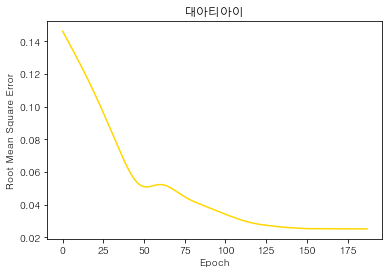

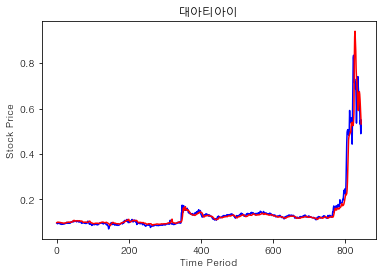

RMSE: 0.025148844
train_cnt: 174
한달 모의투자 결과(100만원 투자): 915,231
마지막 종가(2018.07.03): 7,510
예측 종가: 6,842 (-8.89%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


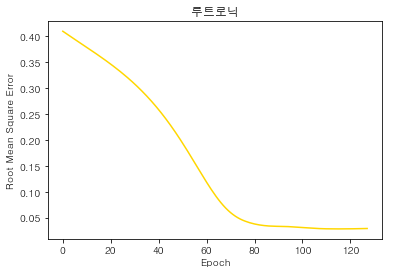

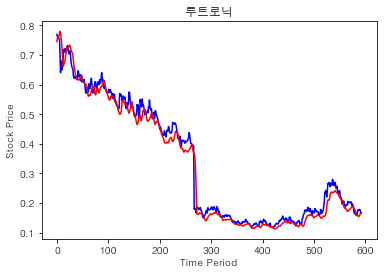

RMSE: 0.029239712
train_cnt: 114
한달 모의투자 결과(100만원 투자): 1,000,000
마지막 종가(2018.07.03): 13,650
예측 종가: 13,641 (-0.06%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


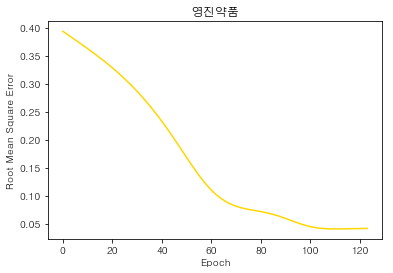

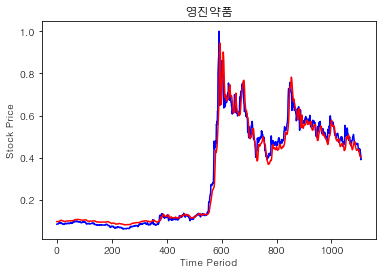

RMSE: 0.041285597
train_cnt: 110
한달 모의투자 결과(100만원 투자): 1,000,000
마지막 종가(2018.07.03): 6,980
예측 종가: 7,111 (1.88%)



In [8]:
comp_names = ["대아티아이", "루트로닉", "영진약품"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


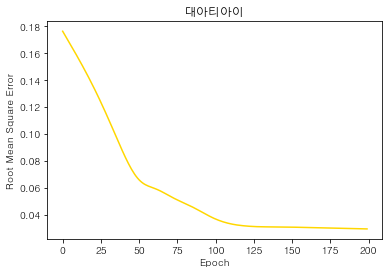

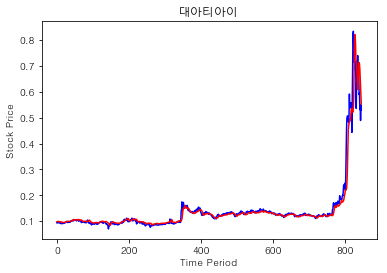

RMSE: 0.029661546
train_cnt: 199
0회 모의투자 결과(100만원 투자): 1,000,000
마지막 종가(2018.07.04): 7,250
예측 종가: 7,143 (-1.48%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


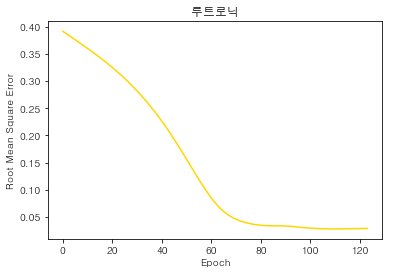

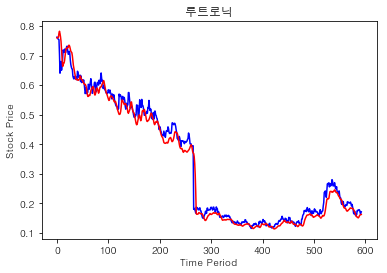

RMSE: 0.02817083
train_cnt: 110
0회 모의투자 결과(100만원 투자): 1,000,000
마지막 종가(2018.07.04): 14,000
예측 종가: 13,421 (-4.14%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


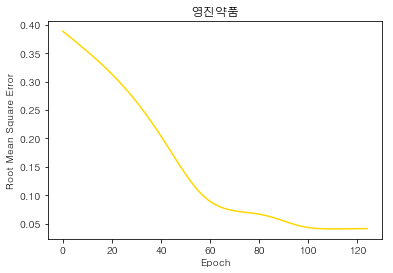

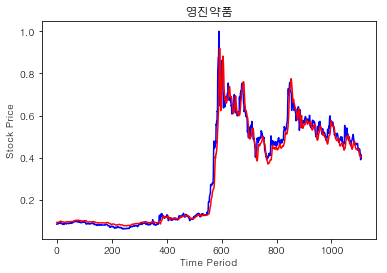

RMSE: 0.04059634
train_cnt: 111
0회 모의투자 결과(100만원 투자): 1,000,000
마지막 종가(2018.07.04): 7,340
예측 종가: 7,005 (-4.57%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


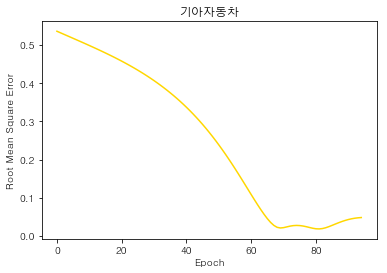

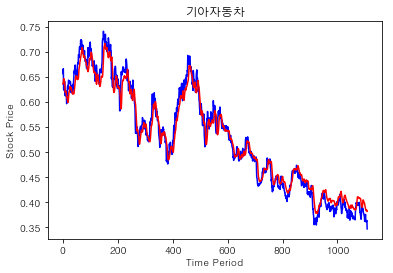

RMSE: 0.018895319
train_cnt: 81
0회 모의투자 결과(100만원 투자): 1,000,000
마지막 종가(2018.07.04): 29,550
예측 종가: 31,848 (7.78%)

INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


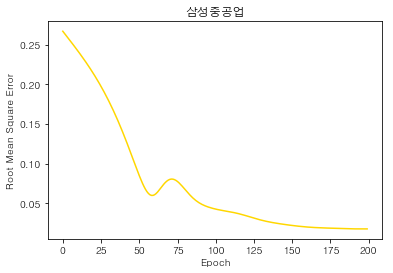

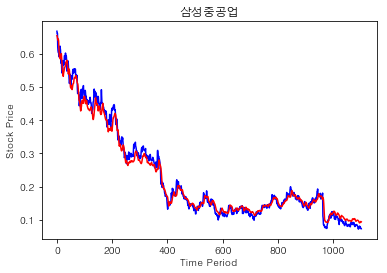

RMSE: 0.017947847
train_cnt: 194
0회 모의투자 결과(100만원 투자): 1,000,000
마지막 종가(2018.07.04): 6,960
예측 종가: 7,927 (13.89%)



In [22]:
comp_names = ["대아티아이", "루트로닉", "영진약품","기아자동차", "삼성중공업"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


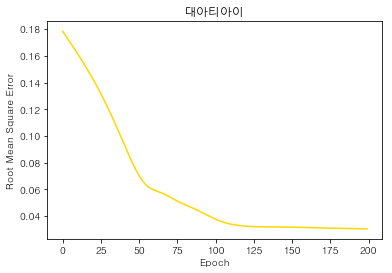

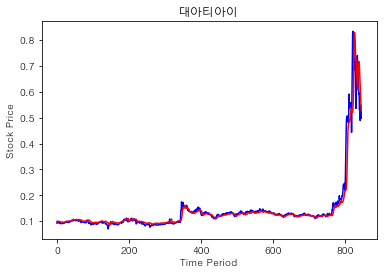

RMSE: 0.03029994
train_cnt: 199
마지막 종가(2018.07.05): 6,820
예측 종가: 6,874 (0.79%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


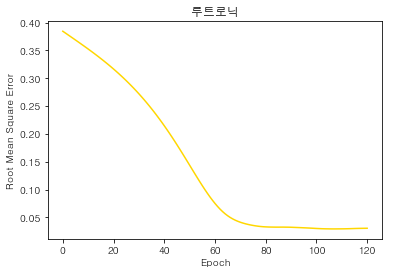

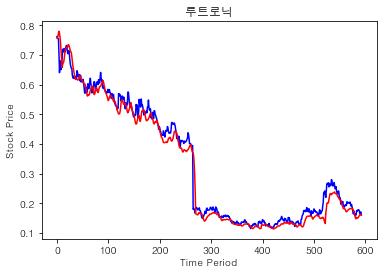

RMSE: 0.029465714
train_cnt: 107
마지막 종가(2018.07.05): 13,300
예측 종가: 13,276 (-0.18%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


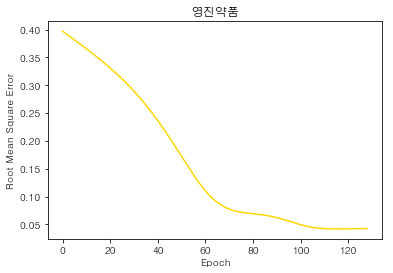

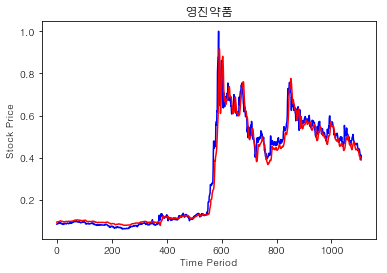

RMSE: 0.041720208
train_cnt: 115
마지막 종가(2018.07.05): 7,140
예측 종가: 6,801 (-4.75%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


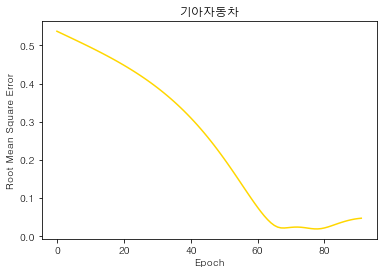

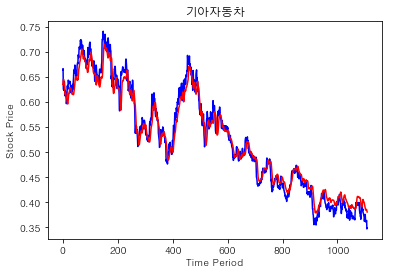

RMSE: 0.019390604
train_cnt: 78
마지막 종가(2018.07.05): 29,700
예측 종가: 31,872 (7.31%)

INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


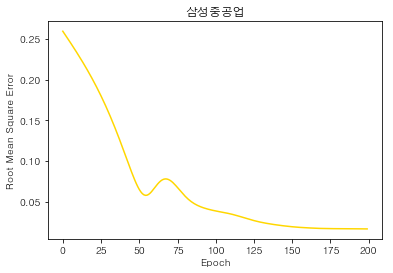

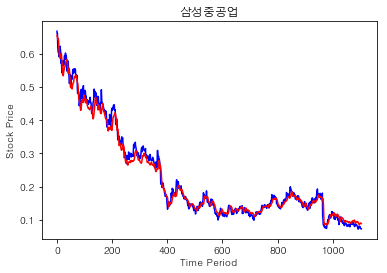

RMSE: 0.016946299
train_cnt: 199
마지막 종가(2018.07.05): 6,940
예측 종가: 7,699 (10.93%)



In [5]:
comp_names = ["대아티아이", "루트로닉", "영진약품","기아자동차", "삼성중공업"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


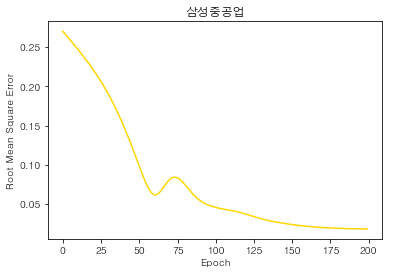

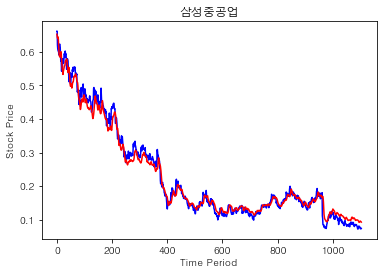

RMSE: 0.018485941
train_cnt: 197
마지막 종가(2018.07.06): 7,020
예측 종가: 7,821 (11.41%)

INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


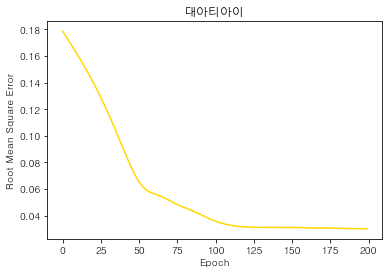

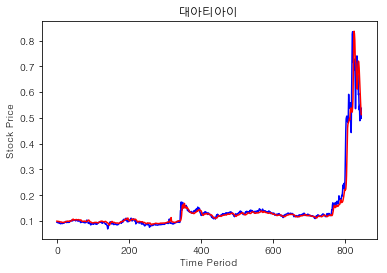

RMSE: 0.030101044
train_cnt: 199
마지막 종가(2018.07.06): 7,350
예측 종가: 6,751 (-8.15%)

INFO:tensorflow:Restoring parameters from ./sessions/033340.ckpt


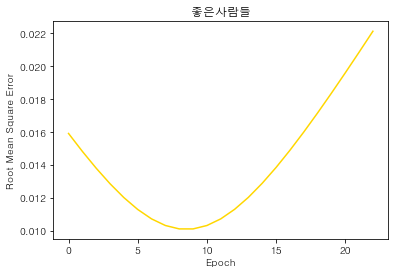

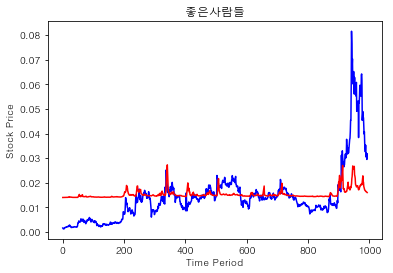

RMSE: 0.010127829
train_cnt: 9
마지막 종가(2018.07.06): 4,010
예측 종가: 2,992 (-25.39%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


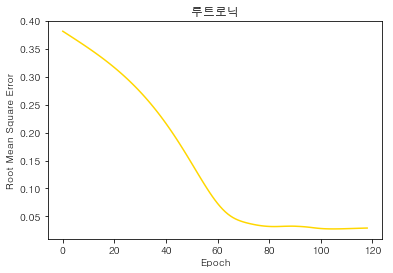

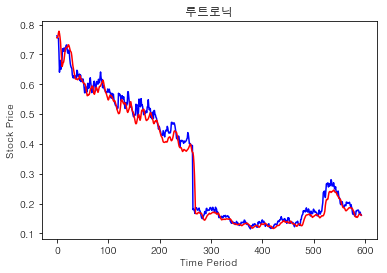

RMSE: 0.027469024
train_cnt: 105
마지막 종가(2018.07.06): 13,350
예측 종가: 13,056 (-2.20%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


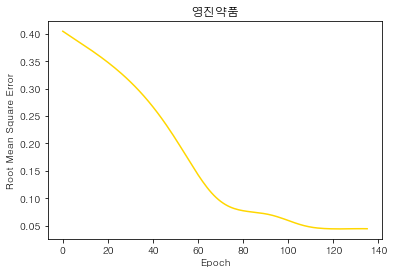

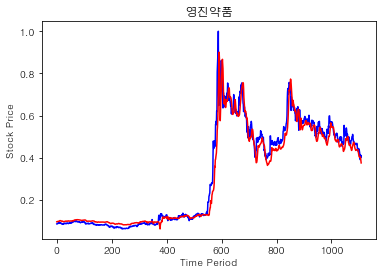

RMSE: 0.043916855
train_cnt: 122
마지막 종가(2018.07.06): 7,250
예측 종가: 6,629 (-8.57%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


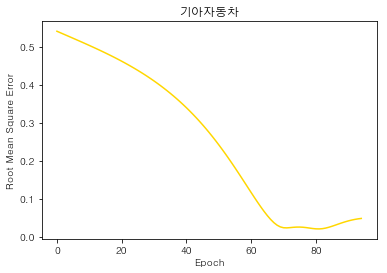

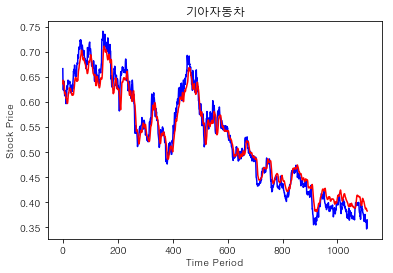

RMSE: 0.020224044
train_cnt: 81
마지막 종가(2018.07.06): 31,050
예측 종가: 31,942 (2.87%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


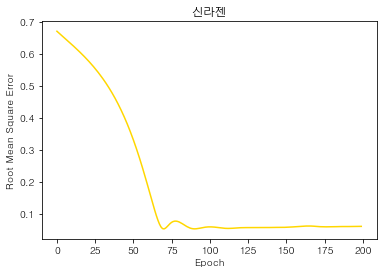

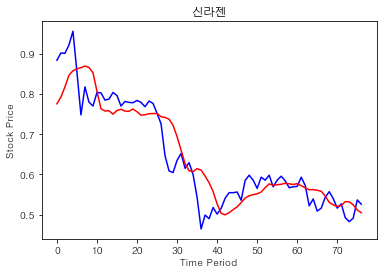

RMSE: 0.053514197
train_cnt: 70
마지막 종가(2018.07.06): 73,200
예측 종가: 67,516 (-7.77%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


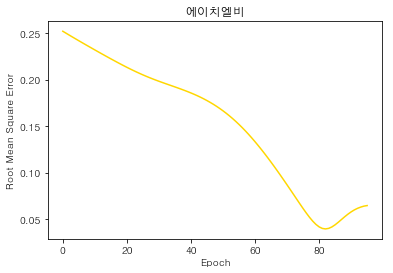

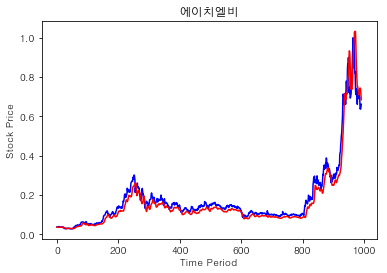

RMSE: 0.039516076
train_cnt: 82
마지막 종가(2018.07.06): 92,600
예측 종가: 90,675 (-2.08%)

INFO:tensorflow:Restoring parameters from ./sessions/005930.ckpt


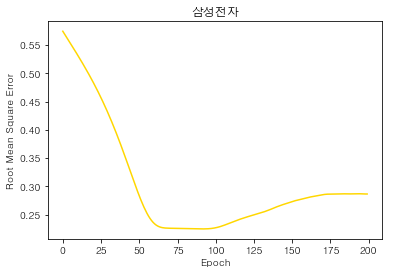

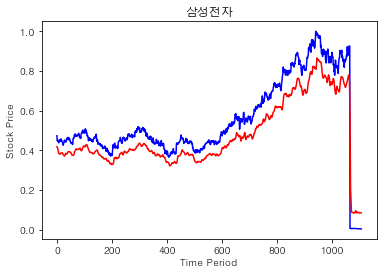

RMSE: 0.22473975
train_cnt: 91
마지막 종가(2018.07.06): 44,900
예측 종가: 238,760 (431.76%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


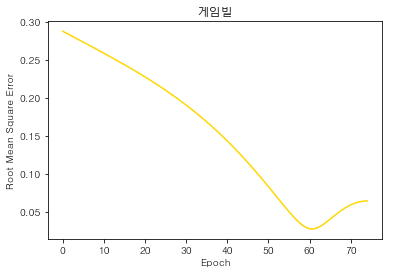

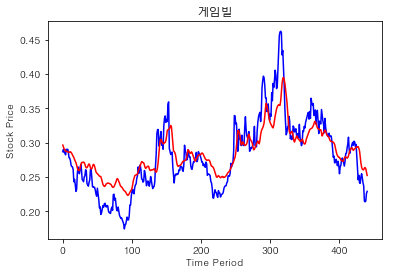

RMSE: 0.027542878
train_cnt: 61
마지막 종가(2018.07.06): 52,600
예측 종가: 62,406 (18.64%)



In [5]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "에이치엘비", "삼성전자", "게임빌", "좋은사람들", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


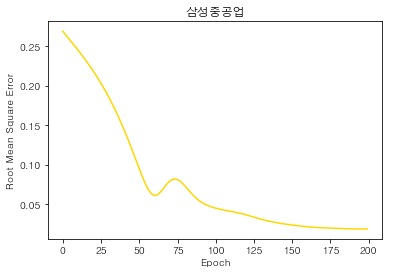

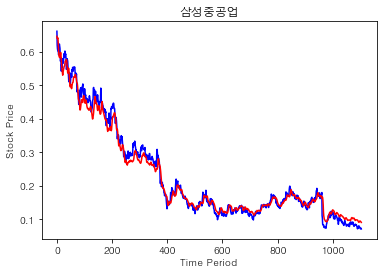

RMSE: 0.018843161
train_cnt: 197
마지막 종가(2018.07.09): 6,900
예측 종가: 7,731 (12.04%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


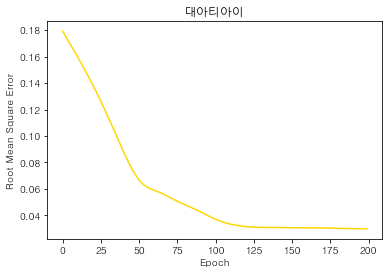

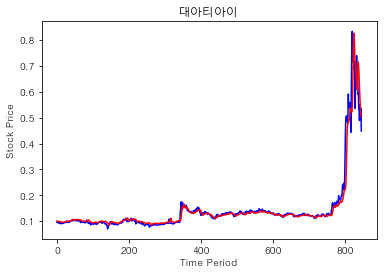

RMSE: 0.029816948
train_cnt: 199
마지막 종가(2018.07.09): 6,170
예측 종가: 6,805 (10.29%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


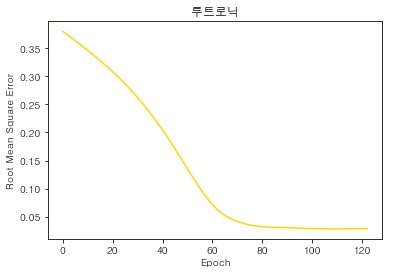

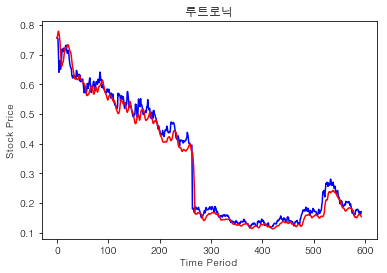

RMSE: 0.028469535
train_cnt: 109
마지막 종가(2018.07.09): 13,900
예측 종가: 13,204 (-5.01%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


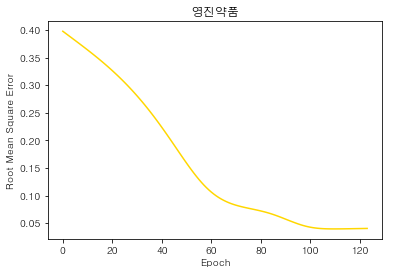

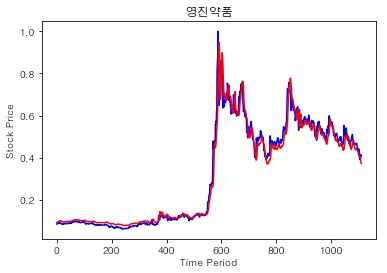

RMSE: 0.039573014
train_cnt: 110
마지막 종가(2018.07.09): 7,330
예측 종가: 6,704 (-8.54%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


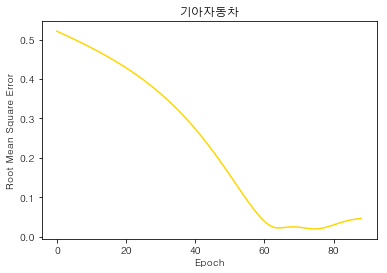

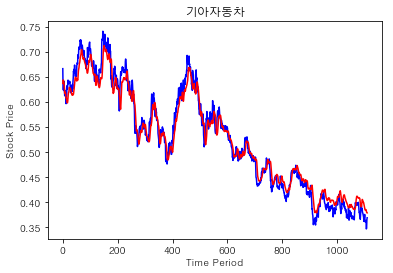

RMSE: 0.019530986
train_cnt: 75
마지막 종가(2018.07.09): 31,400
예측 종가: 31,342 (-0.19%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


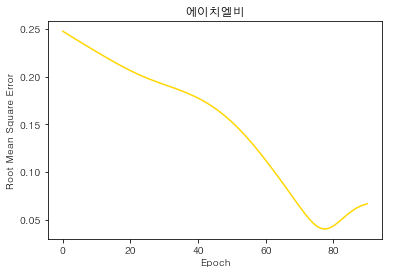

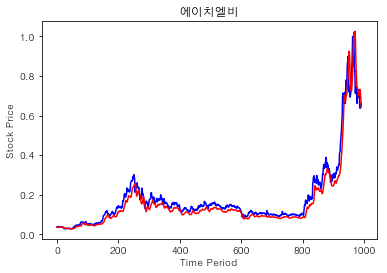

RMSE: 0.040347897
train_cnt: 77
마지막 종가(2018.07.09): 92,100
예측 종가: 88,217 (-4.22%)

INFO:tensorflow:Restoring parameters from ./sessions/005930.ckpt


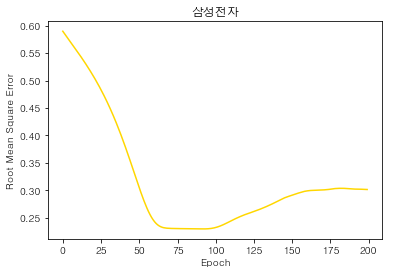

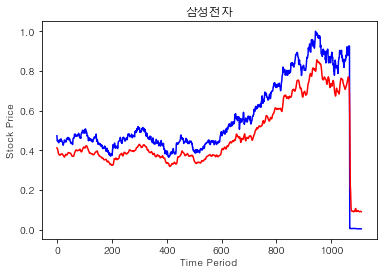

RMSE: 0.22971535
train_cnt: 92
마지막 종가(2018.07.09): 45,600
예측 종가: 249,801 (447.81%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


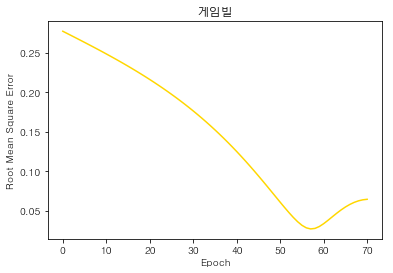

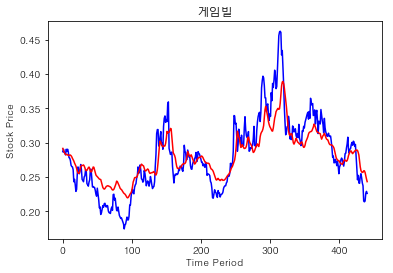

RMSE: 0.027005665
train_cnt: 57
마지막 종가(2018.07.09): 52,100
예측 종가: 56,960 (9.33%)

INFO:tensorflow:Restoring parameters from ./sessions/033340.ckpt


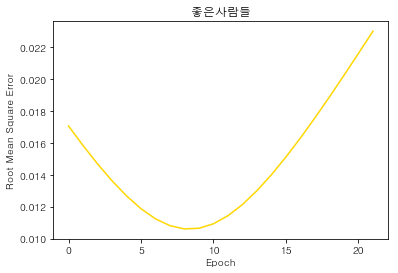

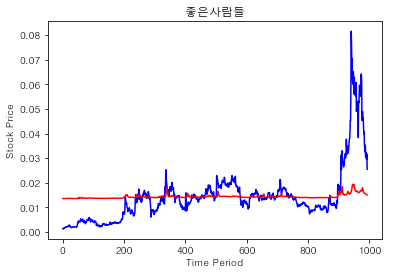

RMSE: 0.010634325
train_cnt: 8
마지막 종가(2018.07.09): 3,430
예측 종가: 3,265 (-4.82%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


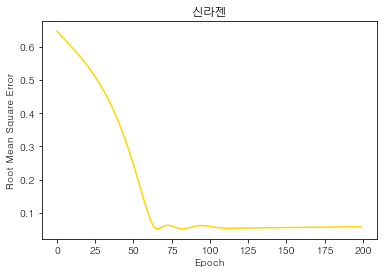

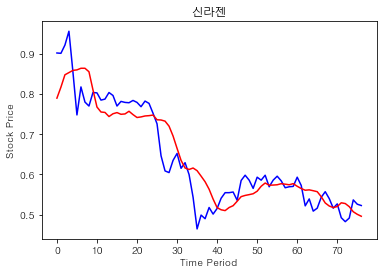

RMSE: 0.051934365
train_cnt: 66
마지막 종가(2018.07.09): 72,800
예측 종가: 69,023 (-5.19%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "에이치엘비", "삼성전자", "게임빌", "좋은사람들", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


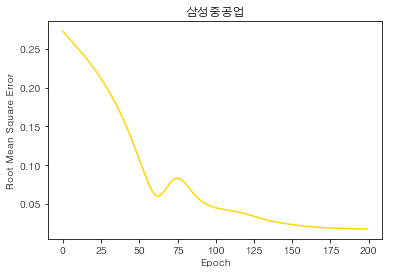

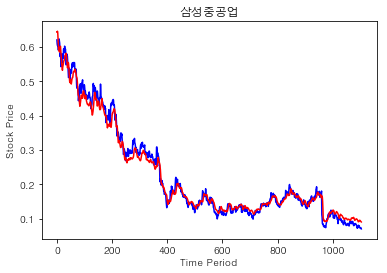

RMSE: 0.01812542
train_cnt: 199
마지막 종가(2018.07.10): 6,810
예측 종가: 7,733 (13.56%)

INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


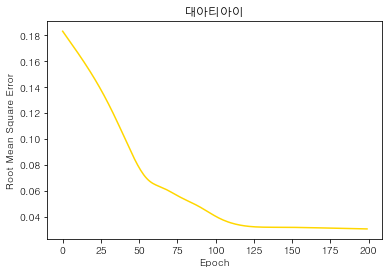

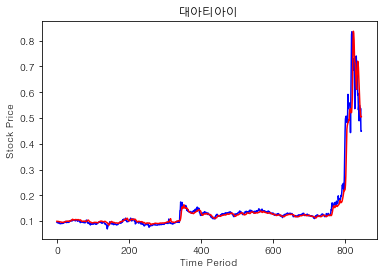

RMSE: 0.030401822
train_cnt: 199
마지막 종가(2018.07.10): 6,170
예측 종가: 6,692 (8.46%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


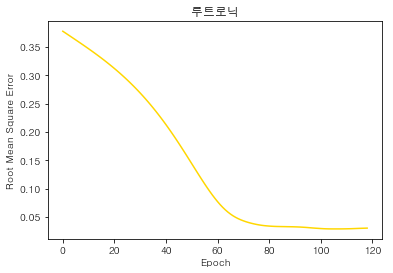

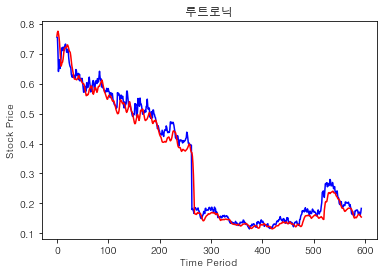

RMSE: 0.028652806
train_cnt: 105
마지막 종가(2018.07.10): 14,850
예측 종가: 13,289 (-10.51%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


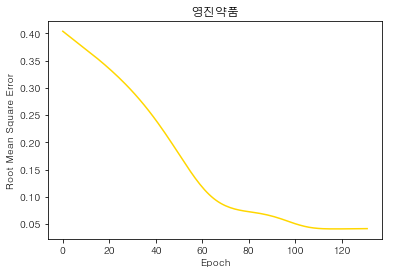

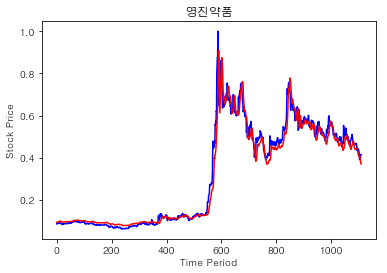

RMSE: 0.040926434
train_cnt: 118
마지막 종가(2018.07.10): 7,370
예측 종가: 6,835 (-7.26%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


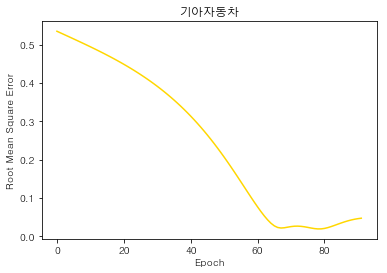

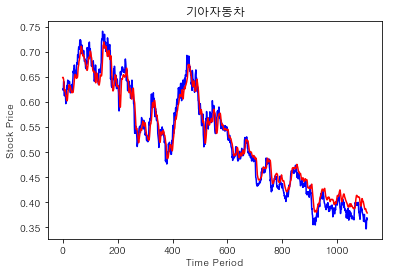

RMSE: 0.01894028
train_cnt: 78
마지막 종가(2018.07.10): 31,100
예측 종가: 31,150 (0.16%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


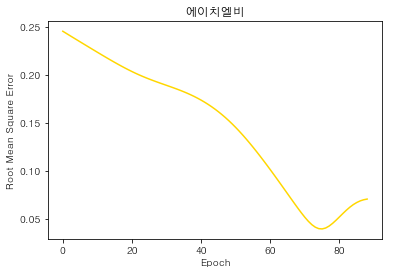

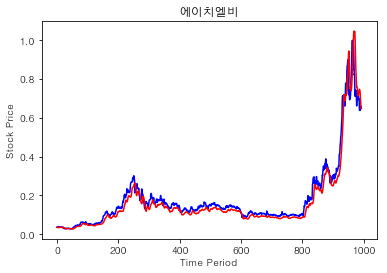

RMSE: 0.039563622
train_cnt: 75
마지막 종가(2018.07.10): 90,700
예측 종가: 89,277 (-1.57%)

INFO:tensorflow:Restoring parameters from ./sessions/005930.ckpt


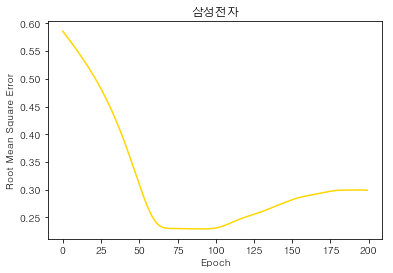

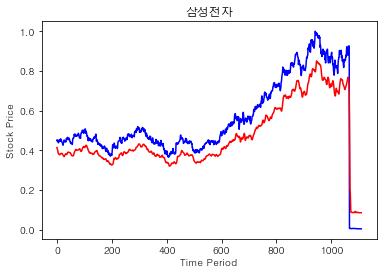

RMSE: 0.22934888
train_cnt: 92
마지막 종가(2018.07.10): 46,300
예측 종가: 232,770 (402.74%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


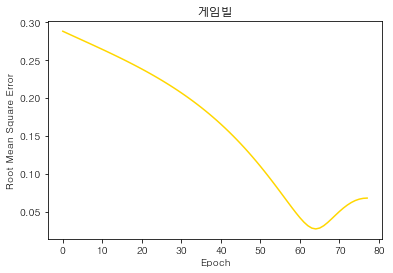

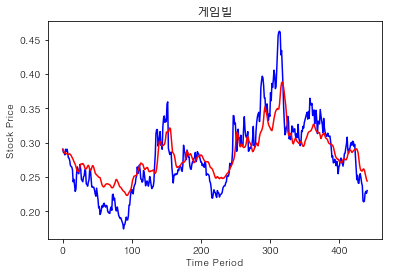

RMSE: 0.027805302
train_cnt: 64
마지막 종가(2018.07.10): 52,800
예측 종가: 56,573 (7.15%)

INFO:tensorflow:Restoring parameters from ./sessions/033340.ckpt


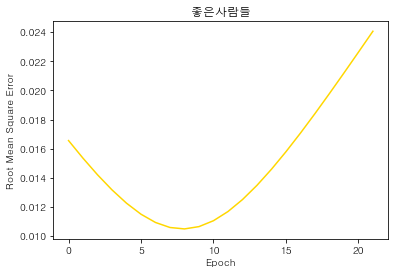

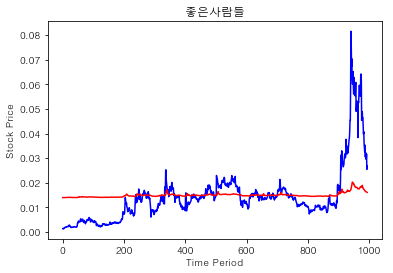

RMSE: 0.010491388
train_cnt: 8
마지막 종가(2018.07.10): 3,550
예측 종가: 3,381 (-4.75%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


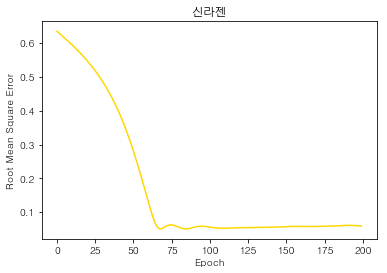

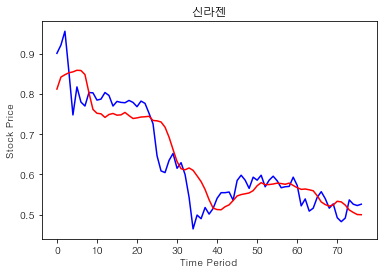

RMSE: 0.05036292
train_cnt: 68
마지막 종가(2018.07.10): 73,200
예측 종가: 70,310 (-3.95%)



In [5]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "에이치엘비", "삼성전자", "게임빌", "좋은사람들", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


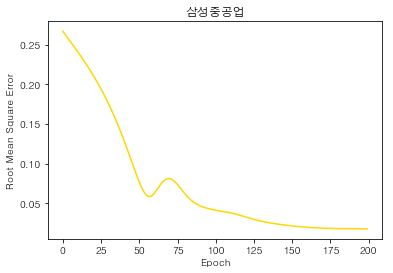

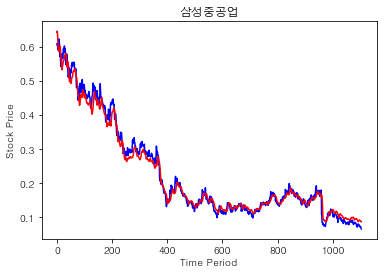

RMSE: 0.01758247
train_cnt: 199
마지막 종가(2018.07.11): 6,620
예측 종가: 7,611 (14.97%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


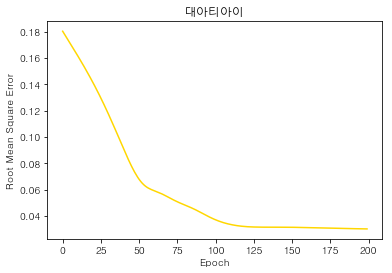

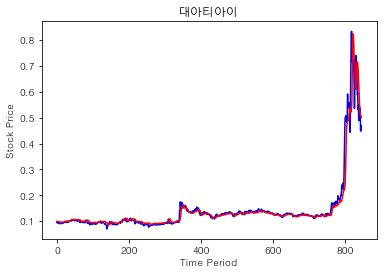

RMSE: 0.030058395
train_cnt: 199
마지막 종가(2018.07.11): 6,450
예측 종가: 6,517 (1.04%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


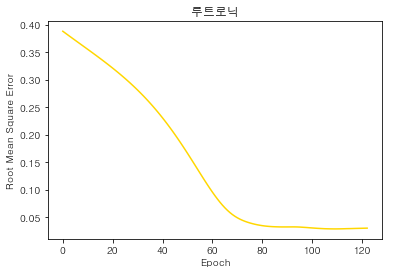

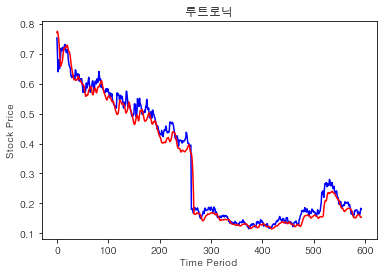

RMSE: 0.028916111
train_cnt: 109
마지막 종가(2018.07.11): 14,700
예측 종가: 13,257 (-9.82%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


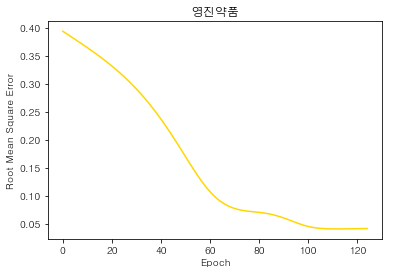

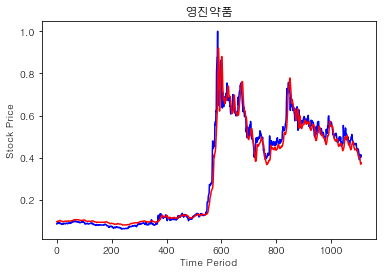

RMSE: 0.04106957
train_cnt: 111
마지막 종가(2018.07.11): 7,190
예측 종가: 6,820 (-5.14%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


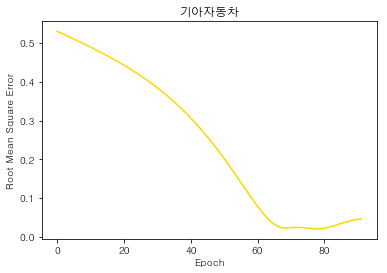

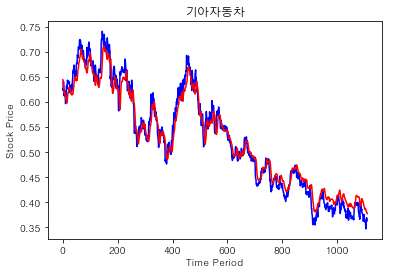

RMSE: 0.01997094
train_cnt: 78
마지막 종가(2018.07.11): 30,900
예측 종가: 31,404 (1.63%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


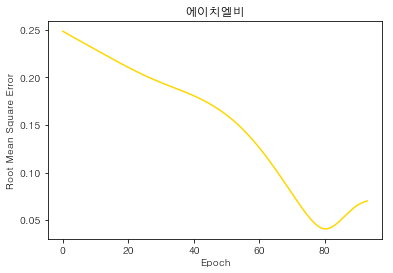

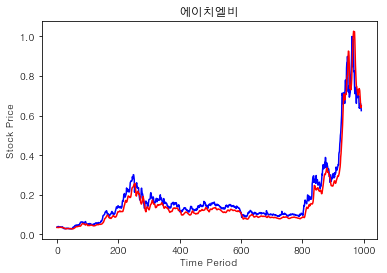

RMSE: 0.04080551
train_cnt: 80
마지막 종가(2018.07.11): 87,500
예측 종가: 90,457 (3.38%)

INFO:tensorflow:Restoring parameters from ./sessions/005930.ckpt


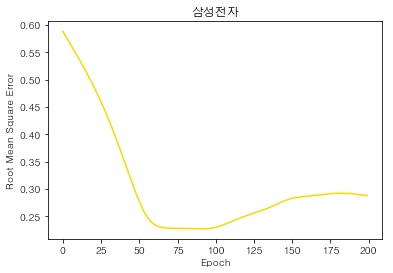

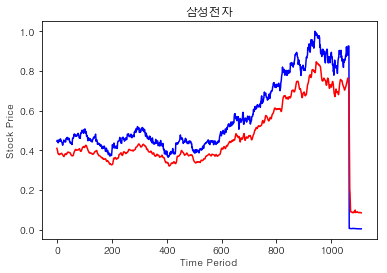

RMSE: 0.22714266
train_cnt: 91
마지막 종가(2018.07.11): 46,000
예측 종가: 232,869 (406.24%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


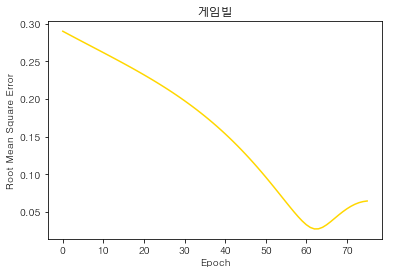

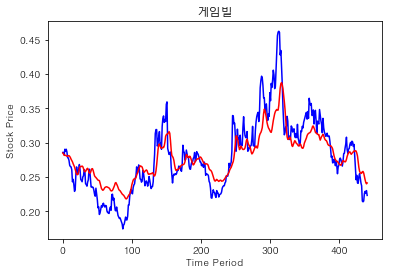

RMSE: 0.027222455
train_cnt: 62
마지막 종가(2018.07.11): 51,600
예측 종가: 57,235 (10.92%)

INFO:tensorflow:Restoring parameters from ./sessions/033340.ckpt


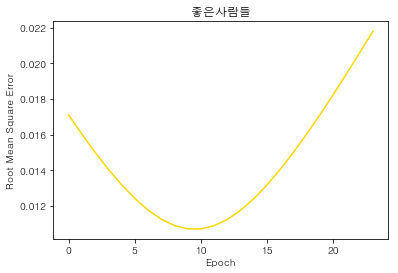

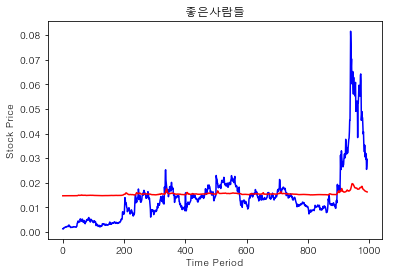

RMSE: 0.010722114
train_cnt: 10
마지막 종가(2018.07.11): 3,810
예측 종가: 3,395 (-10.89%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


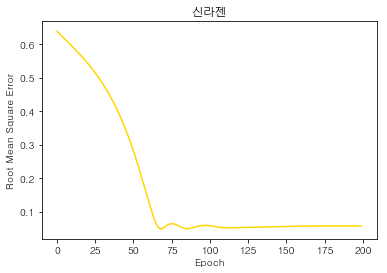

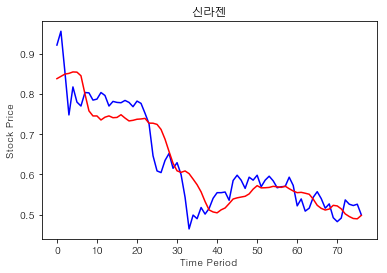

RMSE: 0.049189802
train_cnt: 68
마지막 종가(2018.07.11): 70,000
예측 종가: 70,885 (1.26%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "에이치엘비", "삼성전자", "게임빌", "좋은사람들", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


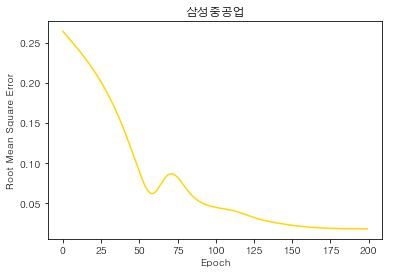

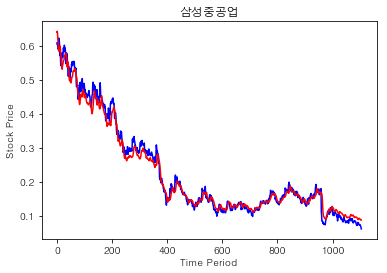

RMSE: 0.018383494
train_cnt: 199
마지막 종가(2018.07.12): 6,380
예측 종가: 7,614 (19.35%)

INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


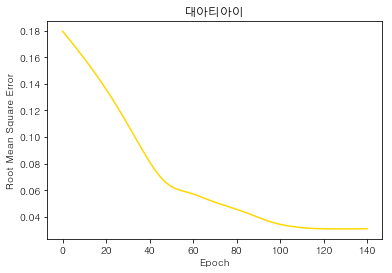

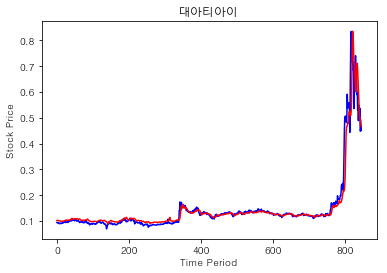

RMSE: 0.030978458
train_cnt: 127
마지막 종가(2018.07.12): 6,210
예측 종가: 6,177 (-0.53%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


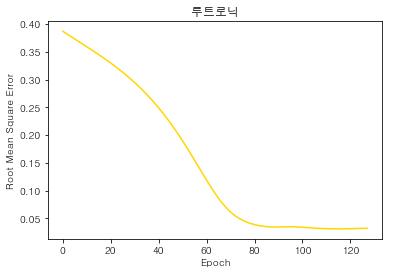

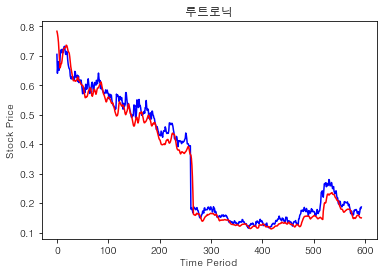

RMSE: 0.030849801
train_cnt: 114
마지막 종가(2018.07.12): 15,100
예측 종가: 13,485 (-10.69%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


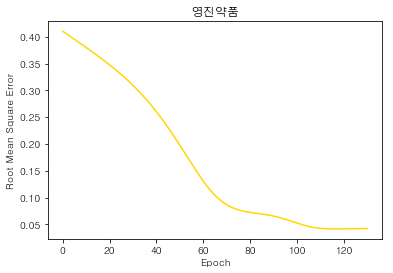

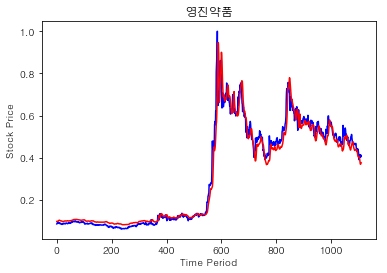

RMSE: 0.041436348
train_cnt: 117
마지막 종가(2018.07.12): 7,280
예측 종가: 6,818 (-6.35%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


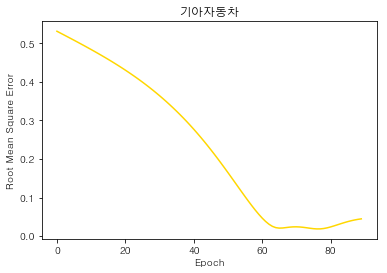

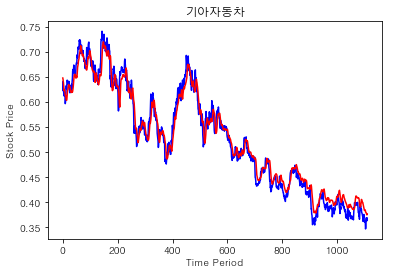

RMSE: 0.018539364
train_cnt: 76
마지막 종가(2018.07.12): 31,350
예측 종가: 31,632 (0.90%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


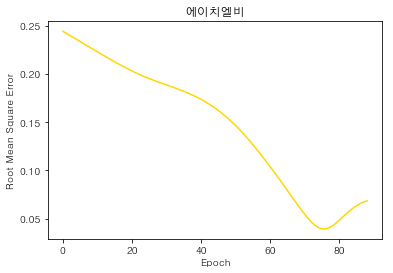

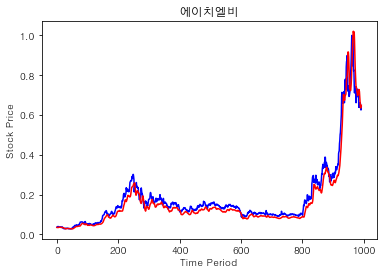

RMSE: 0.03924762
train_cnt: 75
마지막 종가(2018.07.12): 89,800
예측 종가: 90,696 (1.00%)

INFO:tensorflow:Restoring parameters from ./sessions/005930.ckpt


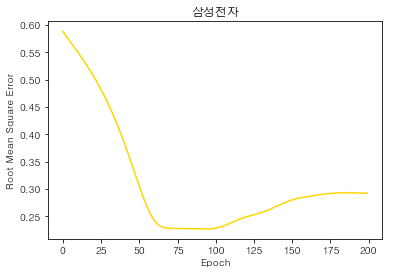

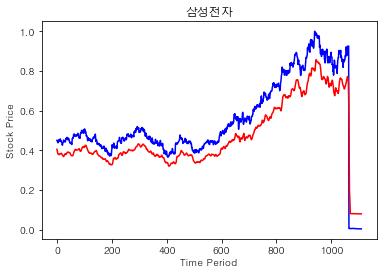

RMSE: 0.22696663
train_cnt: 93
마지막 종가(2018.07.12): 45,500
예측 종가: 222,418 (388.83%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


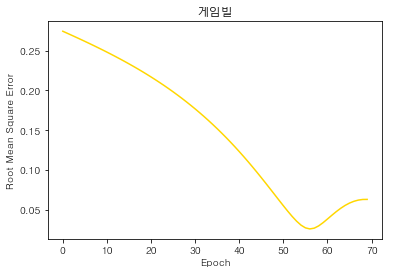

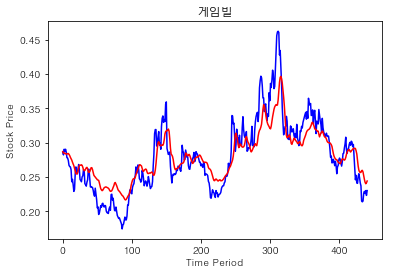

RMSE: 0.026069071
train_cnt: 56
마지막 종가(2018.07.12): 52,800
예측 종가: 57,659 (9.20%)

INFO:tensorflow:Restoring parameters from ./sessions/033340.ckpt


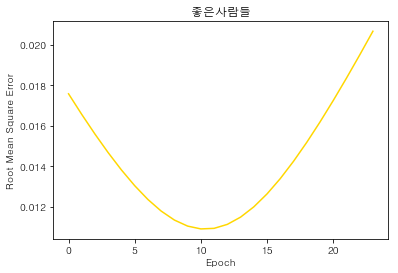

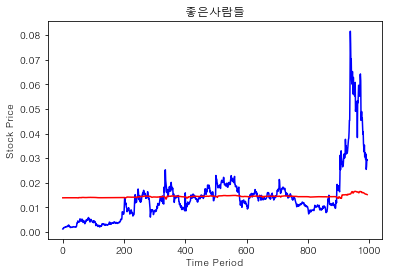

RMSE: 0.010909842
train_cnt: 10
마지막 종가(2018.07.12): 3,780
예측 종가: 3,270 (-13.49%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


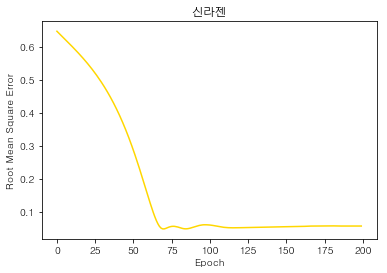

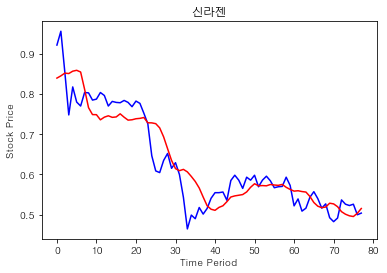

RMSE: 0.04935293
train_cnt: 70
마지막 종가(2018.07.12): 70,500
예측 종가: 71,096 (0.85%)



In [5]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "에이치엘비", "삼성전자", "게임빌", "좋은사람들", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


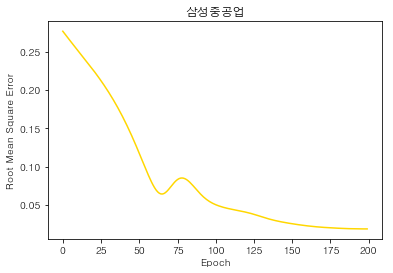

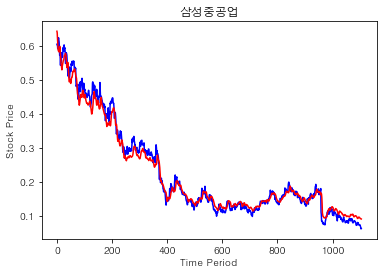

RMSE: 0.018980987
train_cnt: 199
마지막 종가(2018.07.13): 6,420
예측 종가: 7,622 (18.73%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


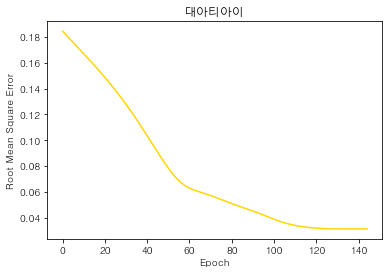

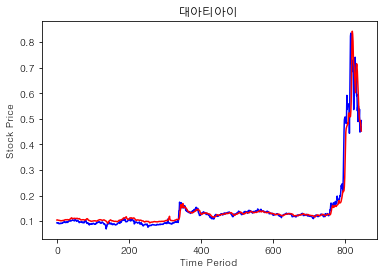

RMSE: 0.031453844
train_cnt: 131
마지막 종가(2018.07.13): 6,760
예측 종가: 5,840 (-13.61%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


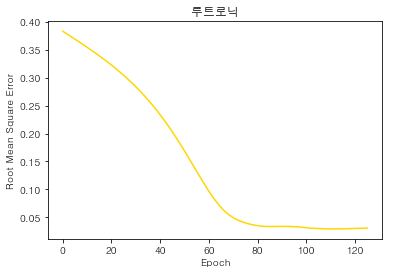

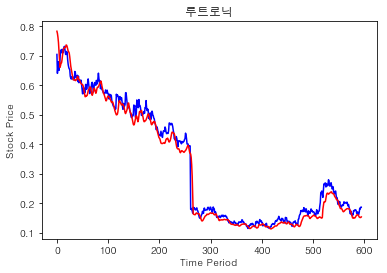

RMSE: 0.029243084
train_cnt: 112
마지막 종가(2018.07.13): 15,100
예측 종가: 13,848 (-8.29%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


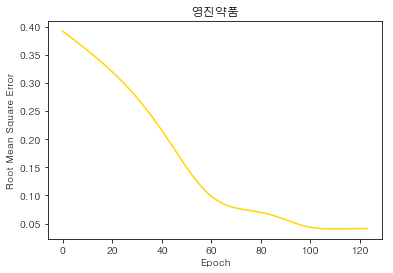

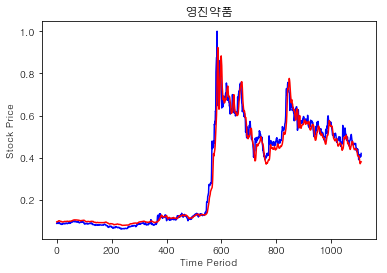

RMSE: 0.04042358
train_cnt: 110
마지막 종가(2018.07.13): 7,470
예측 종가: 6,905 (-7.57%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


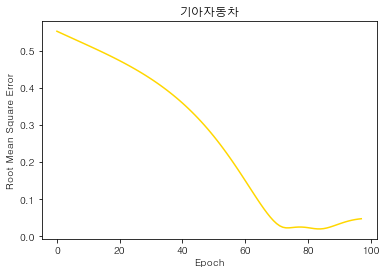

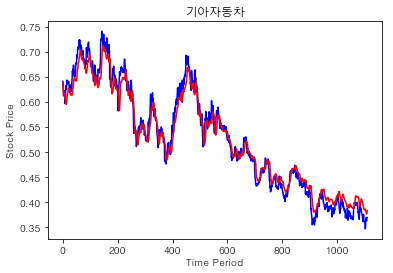

RMSE: 0.019891312
train_cnt: 84
마지막 종가(2018.07.13): 31,450
예측 종가: 32,114 (2.11%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


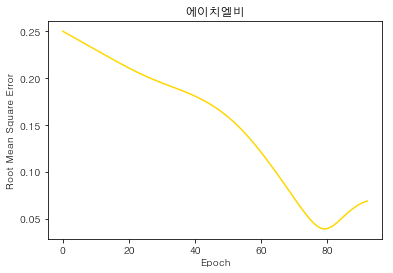

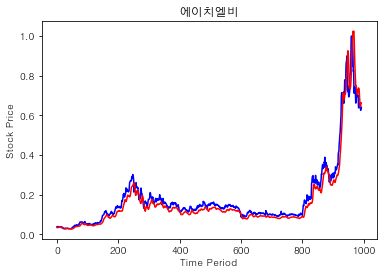

RMSE: 0.039400555
train_cnt: 79
마지막 종가(2018.07.13): 89,500
예측 종가: 92,061 (2.86%)

INFO:tensorflow:Restoring parameters from ./sessions/005930.ckpt


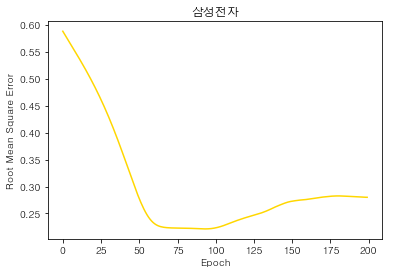

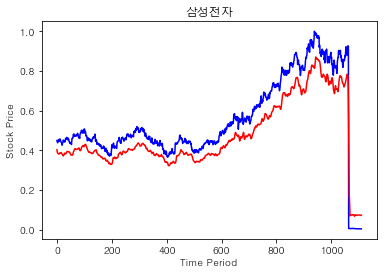

RMSE: 0.22139058
train_cnt: 93
마지막 종가(2018.07.13): 46,500
예측 종가: 209,656 (350.87%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


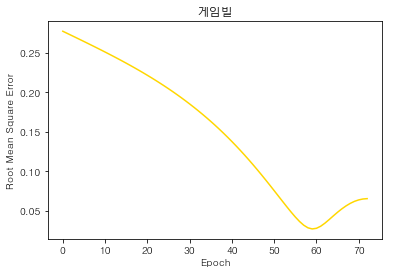

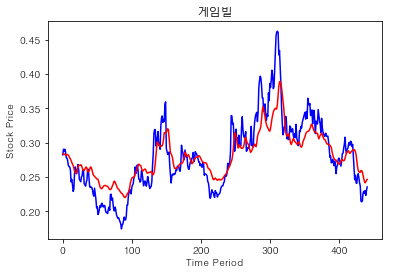

RMSE: 0.027193125
train_cnt: 59
마지막 종가(2018.07.13): 53,700
예측 종가: 57,625 (7.31%)

INFO:tensorflow:Restoring parameters from ./sessions/033340.ckpt


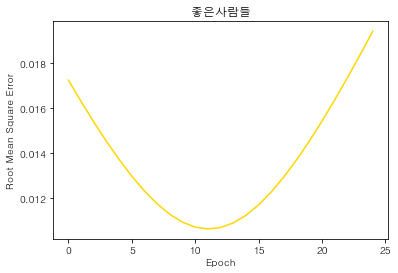

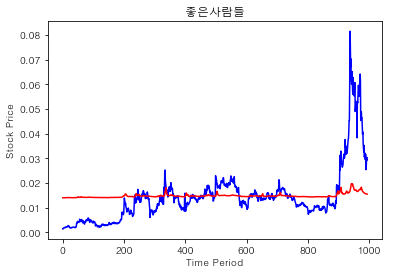

RMSE: 0.010636865
train_cnt: 11
마지막 종가(2018.07.13): 3,880
예측 종가: 3,280 (-15.46%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


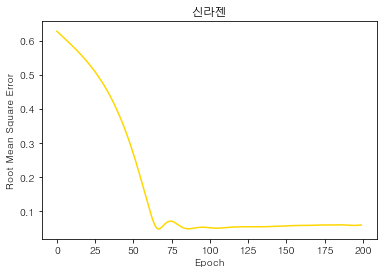

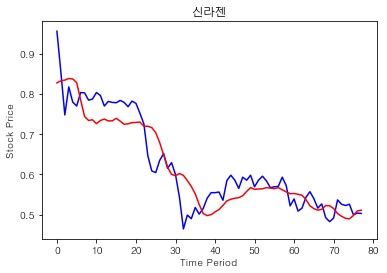

RMSE: 0.0482347
train_cnt: 66
마지막 종가(2018.07.13): 70,400
예측 종가: 71,458 (1.50%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "에이치엘비", "삼성전자", "게임빌", "좋은사람들", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


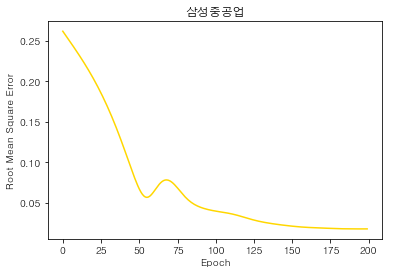

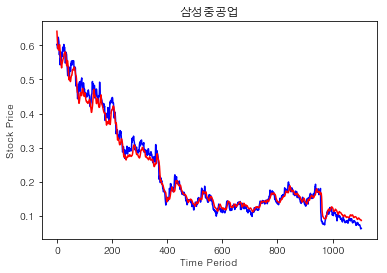

RMSE: 0.017692344
train_cnt: 192
마지막 종가(2018.07.16): 6,450
예측 종가: 7,410 (14.89%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


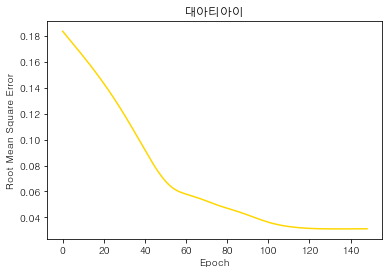

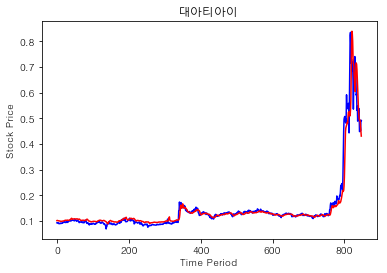

RMSE: 0.031151691
train_cnt: 135
마지막 종가(2018.07.16): 6,740
예측 종가: 5,847 (-13.26%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


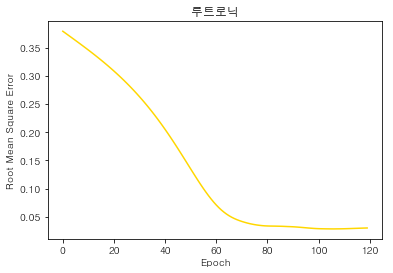

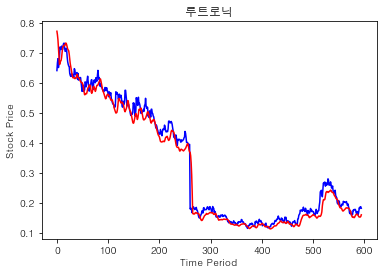

RMSE: 0.028559217
train_cnt: 106
마지막 종가(2018.07.16): 14,750
예측 종가: 14,162 (-3.99%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


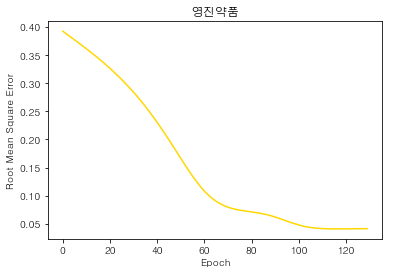

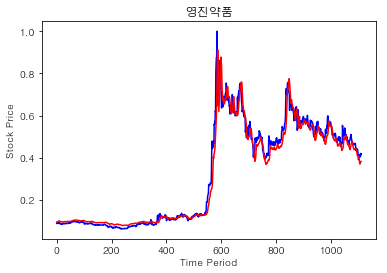

RMSE: 0.040746
train_cnt: 116
마지막 종가(2018.07.16): 7,440
예측 종가: 6,977 (-6.22%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


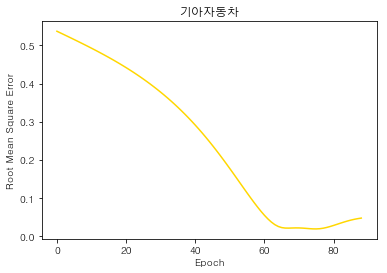

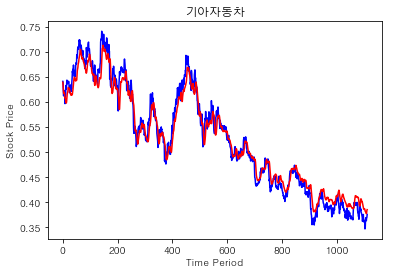

RMSE: 0.0198087
train_cnt: 75
마지막 종가(2018.07.16): 31,950
예측 종가: 32,092 (0.45%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


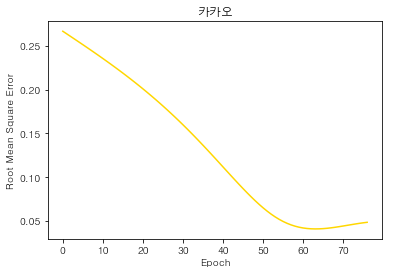

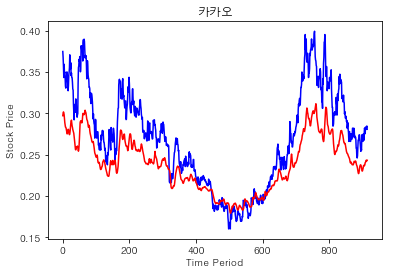

RMSE: 0.041110415
train_cnt: 63
마지막 종가(2018.07.16): 116,500
예측 종가: 114,440 (-1.77%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


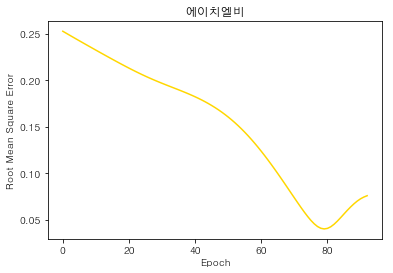

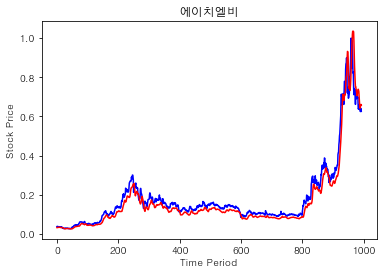

RMSE: 0.040268596
train_cnt: 79
마지막 종가(2018.07.16): 87,600
예측 종가: 88,691 (1.25%)

INFO:tensorflow:Restoring parameters from ./sessions/005930.ckpt


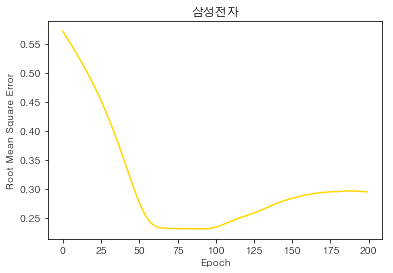

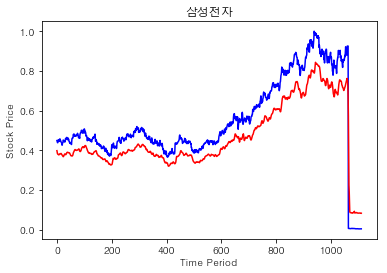

RMSE: 0.23098123
train_cnt: 90
마지막 종가(2018.07.16): 46,050
예측 종가: 225,924 (390.61%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


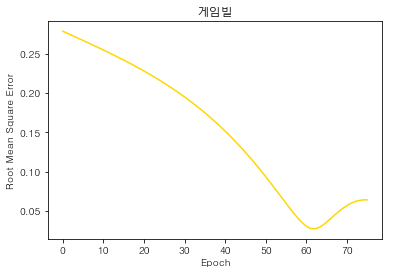

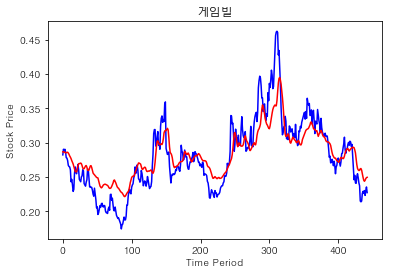

RMSE: 0.027026104
train_cnt: 62
마지막 종가(2018.07.16): 52,300
예측 종가: 57,516 (9.97%)

INFO:tensorflow:Restoring parameters from ./sessions/033340.ckpt


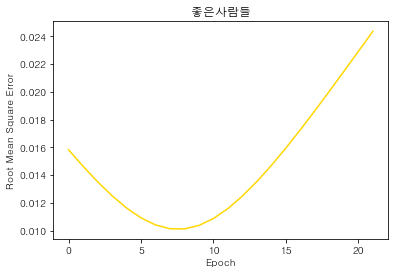

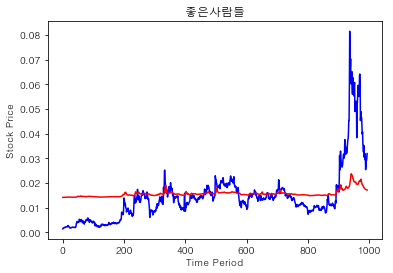

RMSE: 0.010118222
train_cnt: 8
마지막 종가(2018.07.16): 4,035
예측 종가: 3,502 (-13.21%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


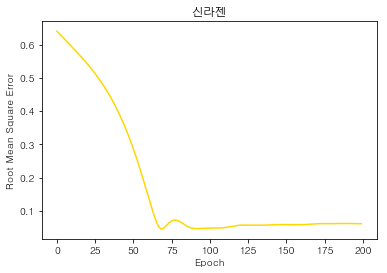

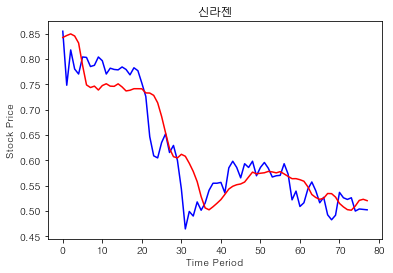

RMSE: 0.04597427
train_cnt: 69
마지막 종가(2018.07.16): 70,300
예측 종가: 70,705 (0.58%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "삼성전자", "게임빌", "좋은사람들", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


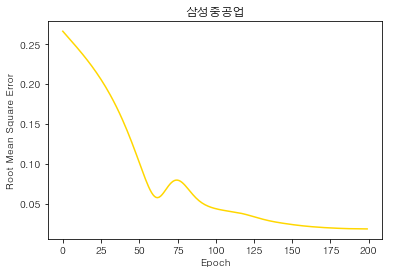

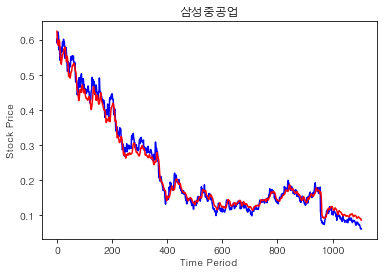

RMSE: 0.018173873
train_cnt: 199
마지막 종가(2018.07.17): 6,340
예측 종가: 7,348 (15.89%)

INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


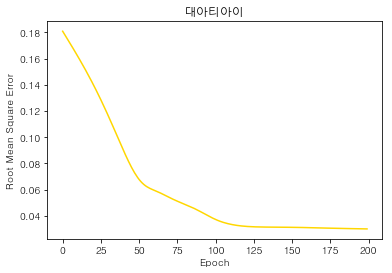

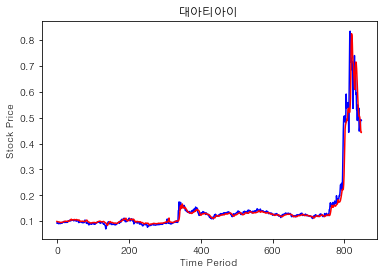

RMSE: 0.03007219
train_cnt: 199
마지막 종가(2018.07.17): 6,720
예측 종가: 6,175 (-8.10%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


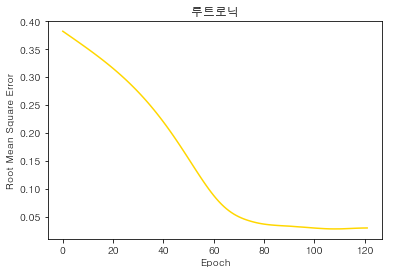

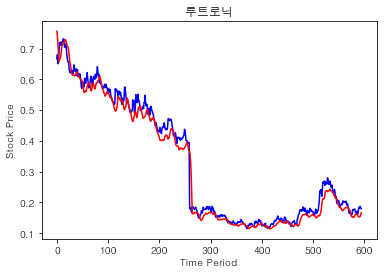

RMSE: 0.027977196
train_cnt: 108
마지막 종가(2018.07.17): 14,600
예측 종가: 14,329 (-1.85%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


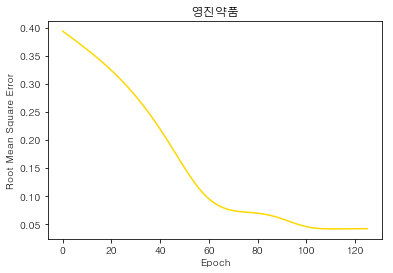

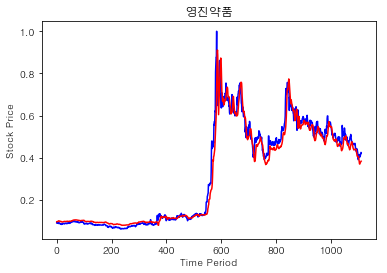

RMSE: 0.04182402
train_cnt: 112
마지막 종가(2018.07.17): 7,540
예측 종가: 6,946 (-7.88%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


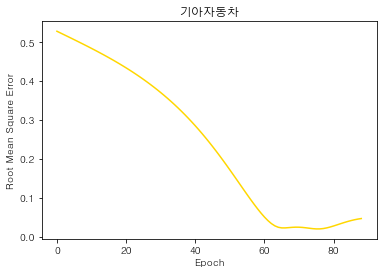

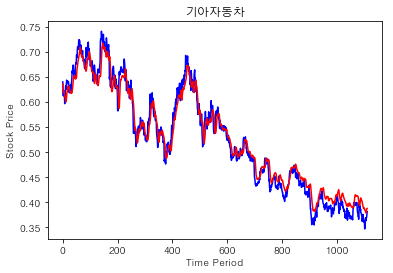

RMSE: 0.019565215
train_cnt: 75
마지막 종가(2018.07.17): 32,400
예측 종가: 32,152 (-0.77%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


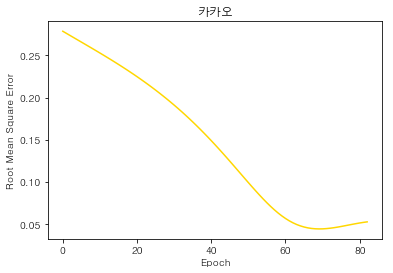

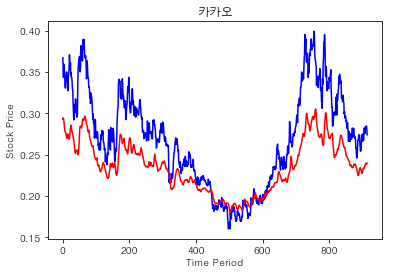

RMSE: 0.04457465
train_cnt: 69
마지막 종가(2018.07.17): 114,000
예측 종가: 114,597 (0.52%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


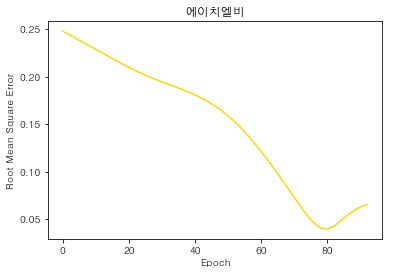

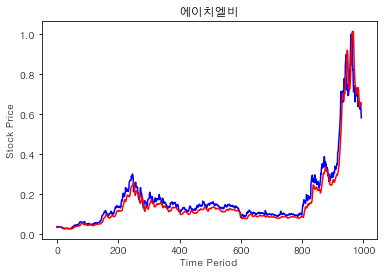

RMSE: 0.03952025
train_cnt: 79
마지막 종가(2018.07.17): 81,500
예측 종가: 88,713 (8.85%)

INFO:tensorflow:Restoring parameters from ./sessions/005930.ckpt


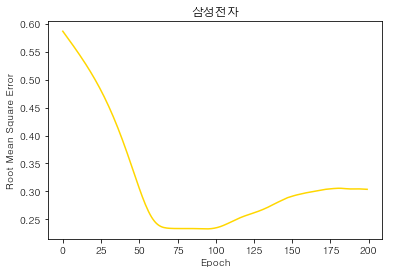

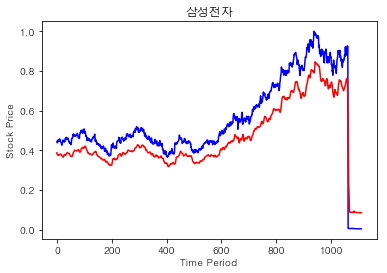

RMSE: 0.23275362
train_cnt: 93
마지막 종가(2018.07.17): 45,850
예측 종가: 228,910 (399.26%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


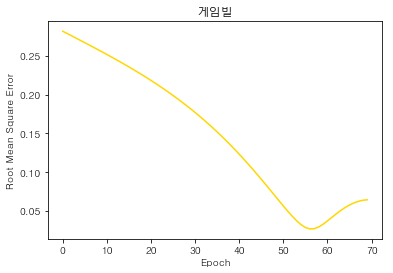

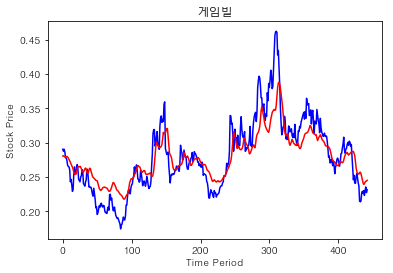

RMSE: 0.027063245
train_cnt: 56
마지막 종가(2018.07.17): 53,000
예측 종가: 58,141 (9.70%)

INFO:tensorflow:Restoring parameters from ./sessions/033340.ckpt


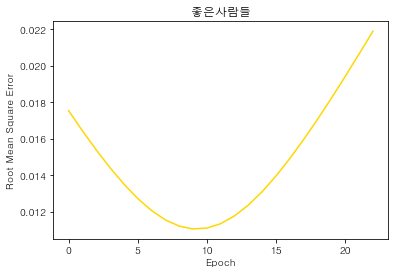

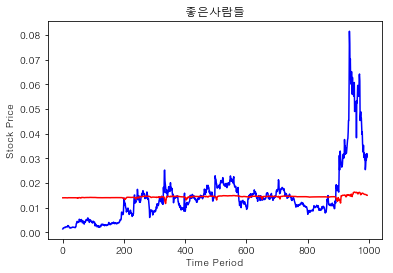

RMSE: 0.011054707
train_cnt: 9
마지막 종가(2018.07.17): 3,915
예측 종가: 3,276 (-16.32%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


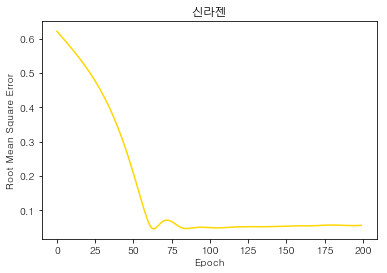

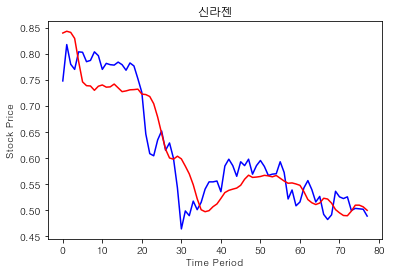

RMSE: 0.045909468
train_cnt: 63
마지막 종가(2018.07.17): 68,700
예측 종가: 68,760 (0.09%)



In [5]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "삼성전자", "게임빌", "좋은사람들", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


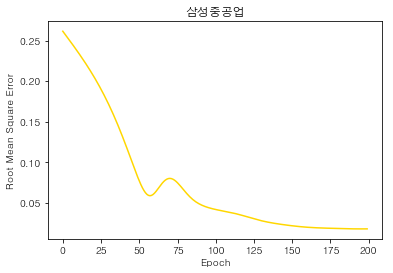

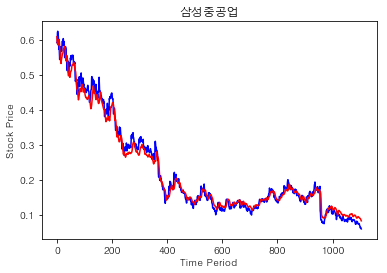

RMSE: 0.017871724
train_cnt: 194
마지막 종가(2018.07.18): 6,220
예측 종가: 7,197 (15.70%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


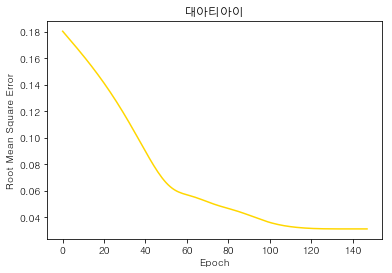

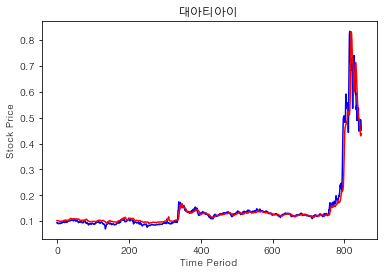

RMSE: 0.031156013
train_cnt: 134
마지막 종가(2018.07.18): 6,220
예측 종가: 6,081 (-2.23%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


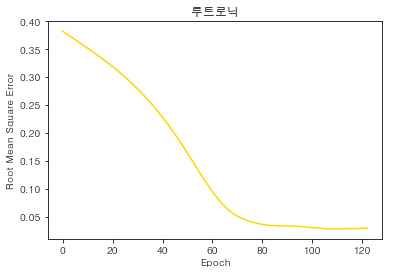

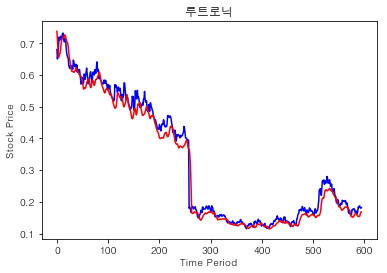

RMSE: 0.028166393
train_cnt: 109
마지막 종가(2018.07.18): 14,750
예측 종가: 14,362 (-2.63%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


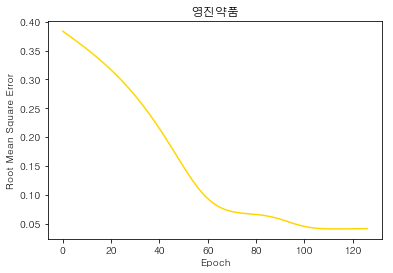

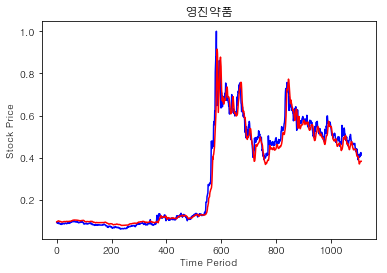

RMSE: 0.04089036
train_cnt: 113
마지막 종가(2018.07.18): 7,330
예측 종가: 7,006 (-4.42%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


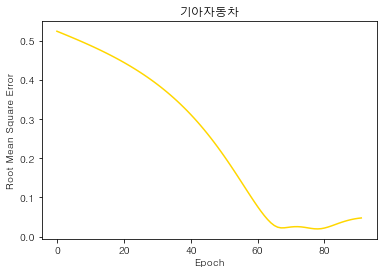

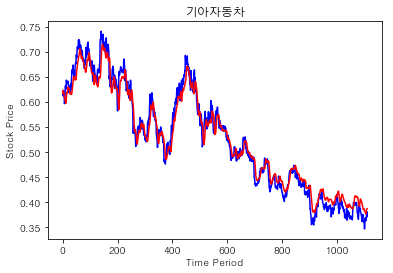

RMSE: 0.019449135
train_cnt: 78
마지막 종가(2018.07.18): 31,600
예측 종가: 32,403 (2.54%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


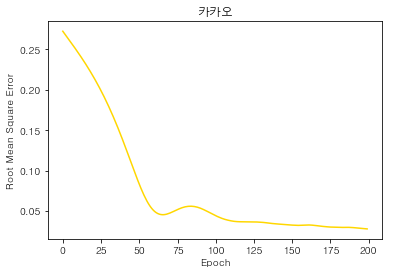

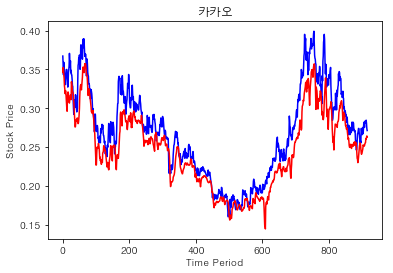

RMSE: 0.027905632
train_cnt: 199
마지막 종가(2018.07.18): 113,000
예측 종가: 115,972 (2.63%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


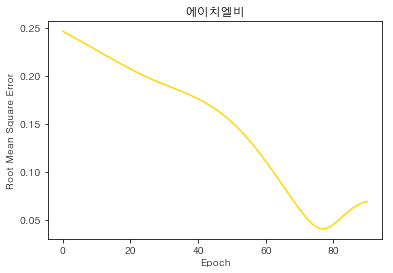

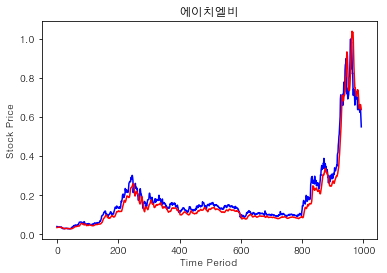

RMSE: 0.04068032
train_cnt: 77
마지막 종가(2018.07.18): 77,000
예측 종가: 87,492 (13.63%)

INFO:tensorflow:Restoring parameters from ./sessions/005930.ckpt


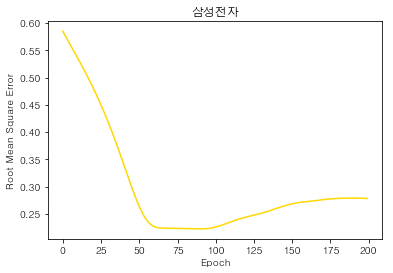

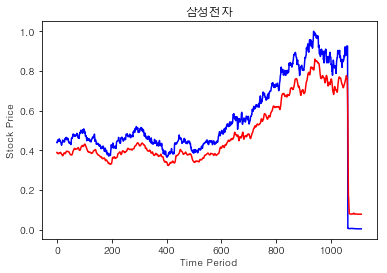

RMSE: 0.22266646
train_cnt: 89
마지막 종가(2018.07.18): 46,550
예측 종가: 215,412 (362.75%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


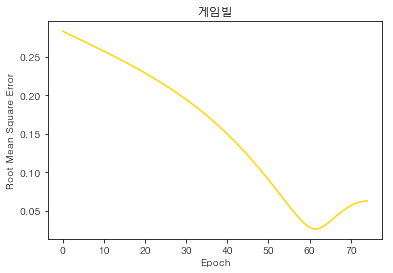

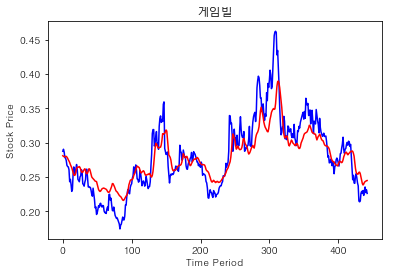

RMSE: 0.026648518
train_cnt: 61
마지막 종가(2018.07.18): 52,100
예측 종가: 57,720 (10.79%)

INFO:tensorflow:Restoring parameters from ./sessions/033340.ckpt


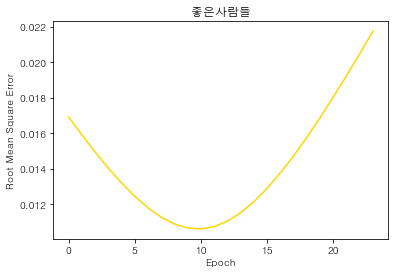

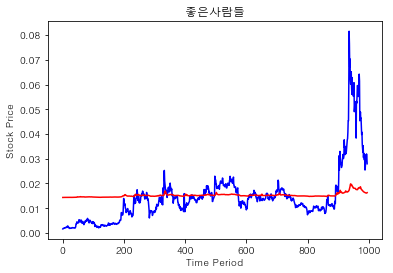

RMSE: 0.010617242
train_cnt: 10
마지막 종가(2018.07.18): 3,665
예측 종가: 3,392 (-7.45%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


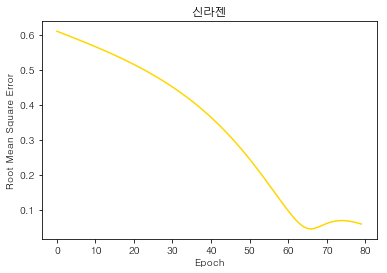

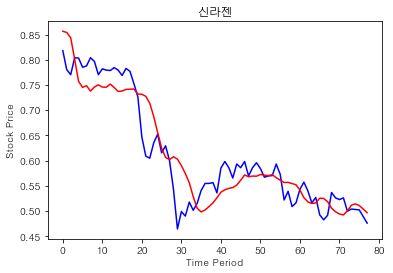

RMSE: 0.044511966
train_cnt: 66
마지막 종가(2018.07.18): 67,100
예측 종가: 68,349 (1.86%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "삼성전자", "게임빌", "좋은사람들", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


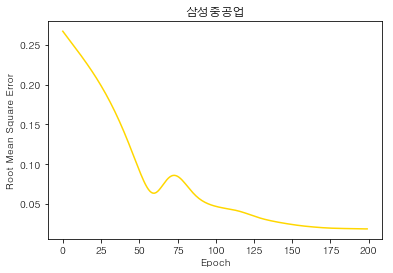

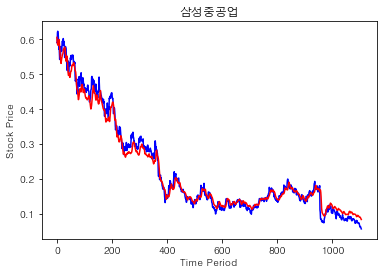

RMSE: 0.01875174
train_cnt: 197
마지막 종가(2018.07.19): 6,090
예측 종가: 7,240 (18.89%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


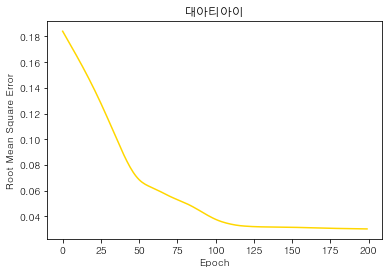

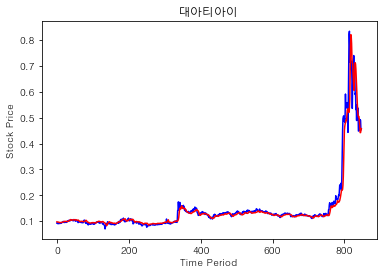

RMSE: 0.030220151
train_cnt: 199
마지막 종가(2018.07.19): 6,270
예측 종가: 6,282 (0.20%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


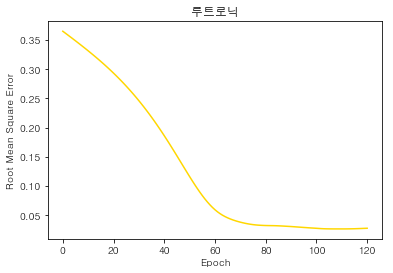

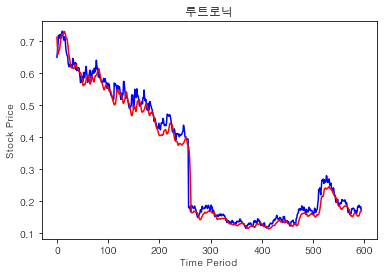

RMSE: 0.02645762
train_cnt: 107
마지막 종가(2018.07.19): 14,000
예측 종가: 14,387 (2.76%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


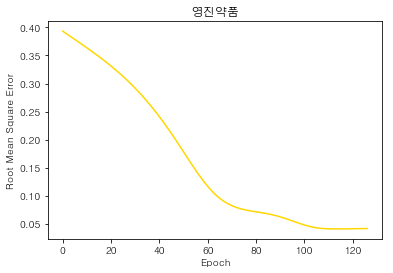

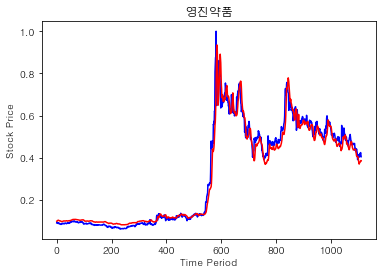

RMSE: 0.04094102
train_cnt: 113
마지막 종가(2018.07.19): 7,200
예측 종가: 7,060 (-1.94%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


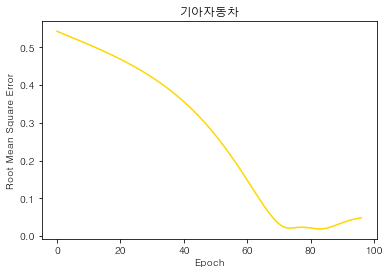

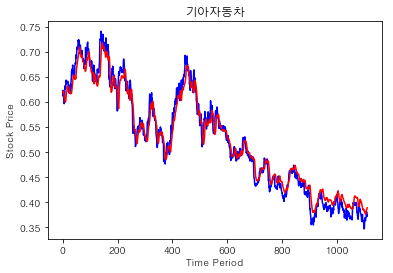

RMSE: 0.019030025
train_cnt: 83
마지막 종가(2018.07.19): 31,900
예측 종가: 32,457 (1.75%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


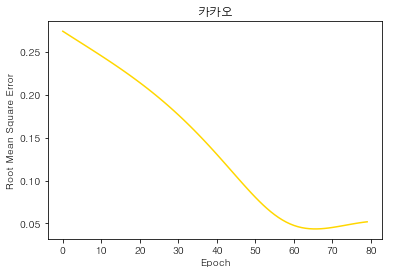

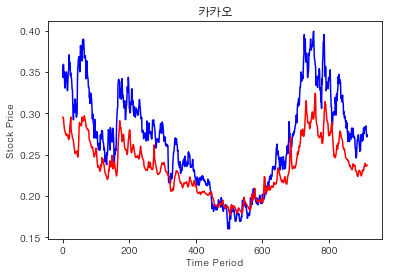

RMSE: 0.043611802
train_cnt: 66
마지막 종가(2018.07.19): 114,000
예측 종가: 112,406 (-1.40%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


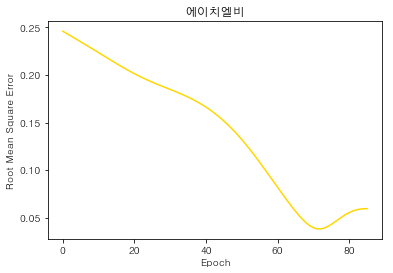

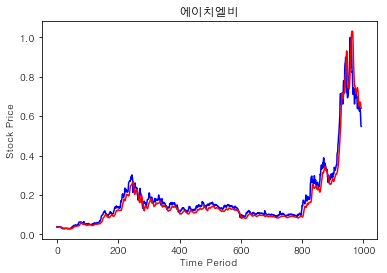

RMSE: 0.038121104
train_cnt: 72
마지막 종가(2018.07.19): 76,700
예측 종가: 85,928 (12.03%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


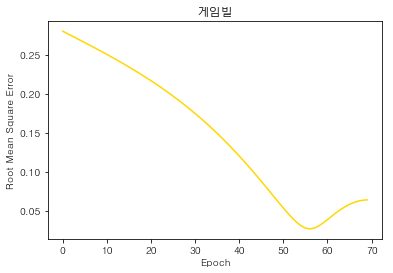

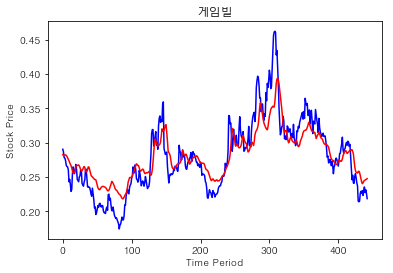

RMSE: 0.02660994
train_cnt: 56
마지막 종가(2018.07.19): 50,800
예측 종가: 58,312 (14.79%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


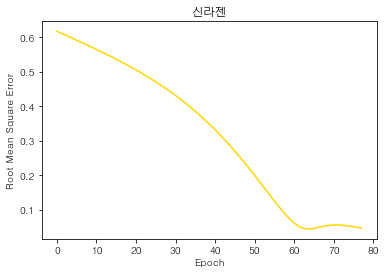

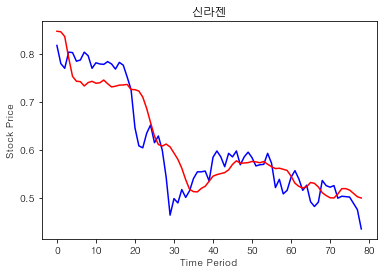

RMSE: 0.044849165
train_cnt: 64
마지막 종가(2018.07.19): 62,200
예측 종가: 68,643 (10.36%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "게임빌", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/001510.ckpt


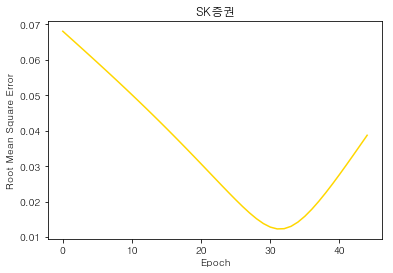

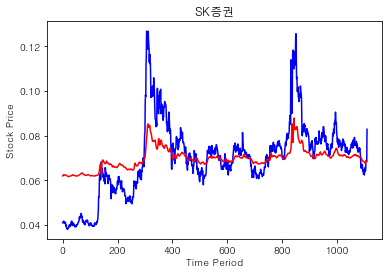

RMSE: 0.012303432
train_cnt: 31
마지막 종가(2018.07.19): 1,300
예측 종가: 1,456 (12.00%)

INFO:tensorflow:Restoring parameters from ./sessions/010690.ckpt


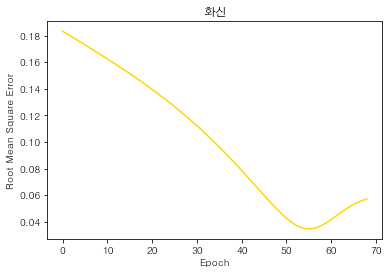

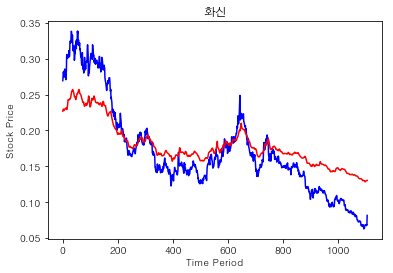

RMSE: 0.03460405
train_cnt: 55
마지막 종가(2018.07.19): 3,700
예측 종가: 5,605 (51.47%)

INFO:tensorflow:Restoring parameters from ./sessions/024910.ckpt


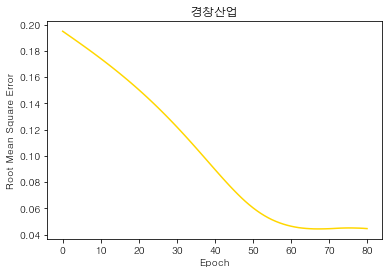

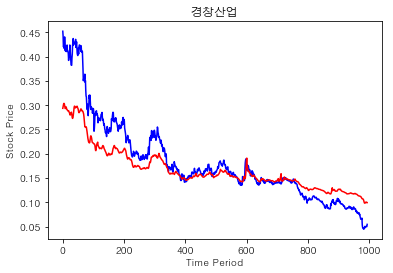

RMSE: 0.044303857
train_cnt: 67
마지막 종가(2018.07.19): 2,380
예측 종가: 3,720 (56.31%)

INFO:tensorflow:Restoring parameters from ./sessions/059100.ckpt


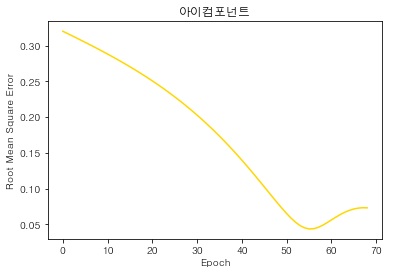

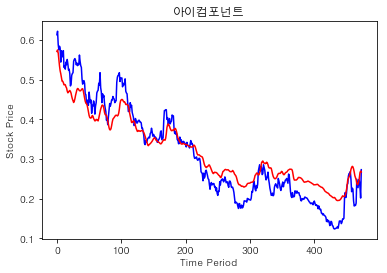

RMSE: 0.043388803
train_cnt: 55
마지막 종가(2018.07.19): 8,500
예측 종가: 8,658 (1.86%)

INFO:tensorflow:Restoring parameters from ./sessions/033430.ckpt


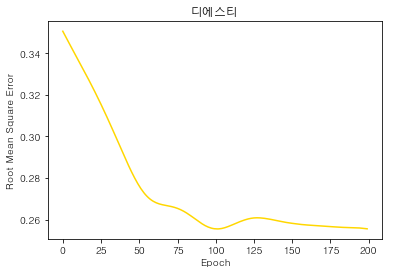

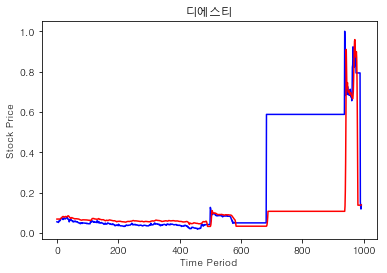

RMSE: 0.25551713
train_cnt: 101
마지막 종가(2018.07.19): 1,250
예측 종가: 3,269 (161.50%)



In [5]:
comp_names = ["SK증권", "화신","경창산업", "아이컴포넌트","디에스티"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


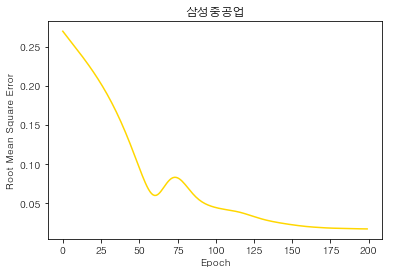

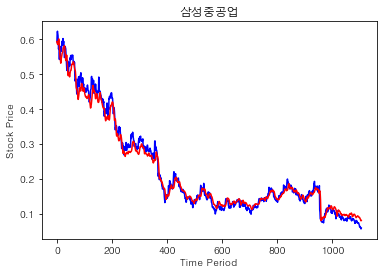

RMSE: 0.017470207
train_cnt: 199
마지막 종가(2018.07.20): 6,200
예측 종가: 7,169 (15.63%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


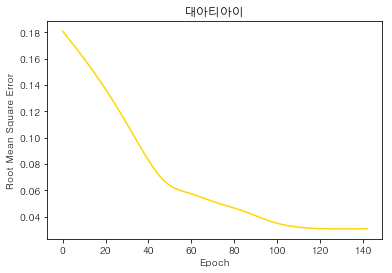

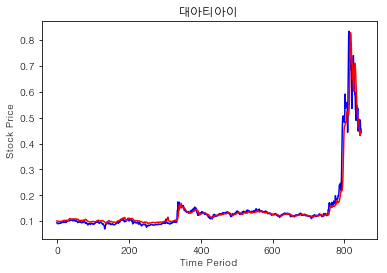

RMSE: 0.030591695
train_cnt: 129
마지막 종가(2018.07.20): 6,100
예측 종가: 6,135 (0.58%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


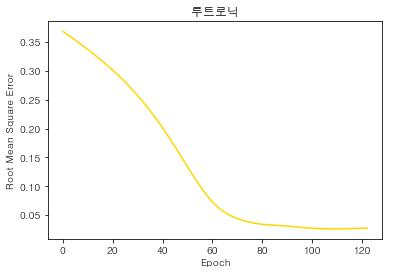

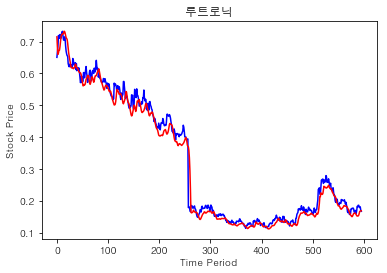

RMSE: 0.026133755
train_cnt: 109
마지막 종가(2018.07.20): 13,800
예측 종가: 14,262 (3.34%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


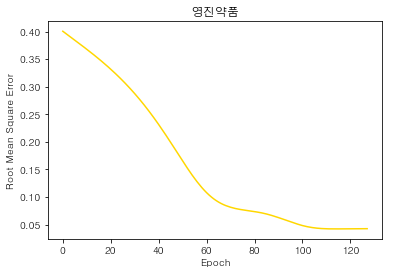

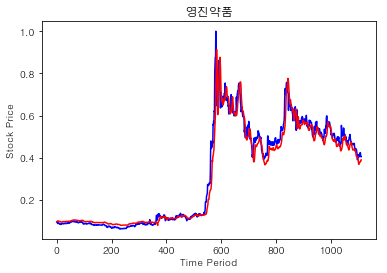

RMSE: 0.042059302
train_cnt: 114
마지막 종가(2018.07.20): 7,200
예측 종가: 7,065 (-1.87%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


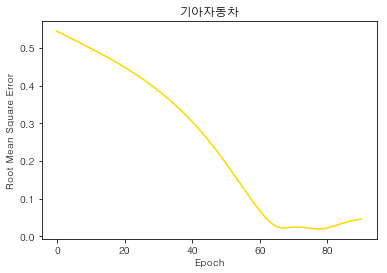

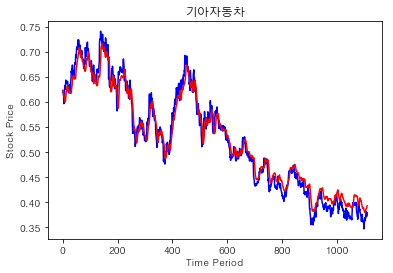

RMSE: 0.019583002
train_cnt: 77
마지막 종가(2018.07.20): 32,200
예측 종가: 32,724 (1.63%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


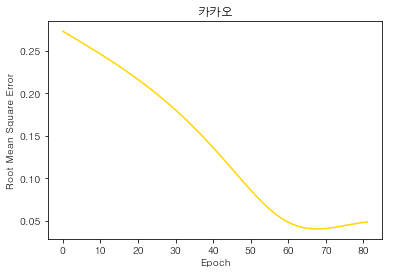

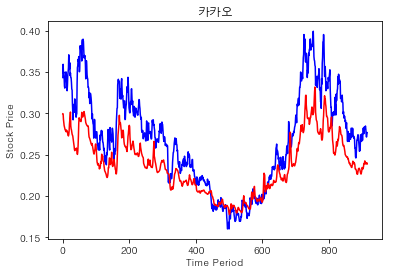

RMSE: 0.04058616
train_cnt: 68
마지막 종가(2018.07.20): 115,000
예측 종가: 111,751 (-2.83%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


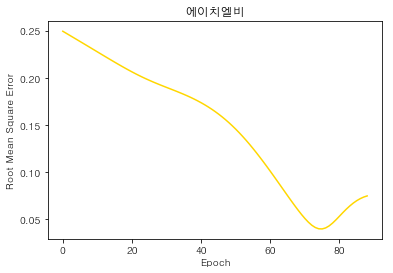

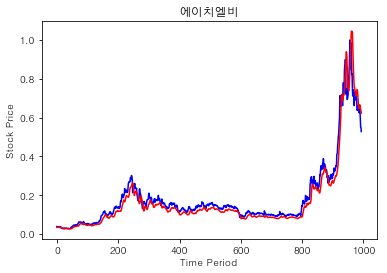

RMSE: 0.039910495
train_cnt: 75
마지막 종가(2018.07.20): 73,900
예측 종가: 81,585 (10.40%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


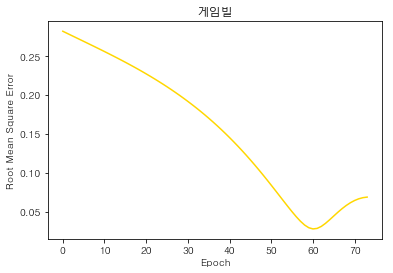

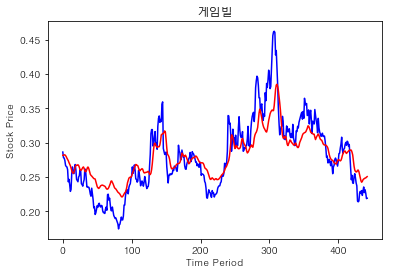

RMSE: 0.027821058
train_cnt: 60
마지막 종가(2018.07.20): 50,900
예측 종가: 58,138 (14.22%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


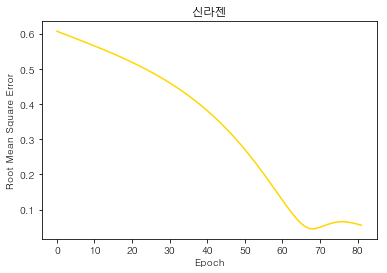

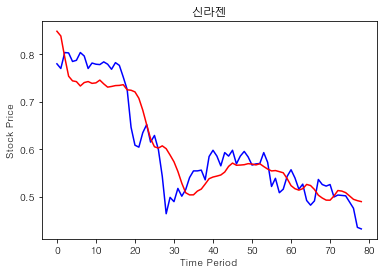

RMSE: 0.044723287
train_cnt: 68
마지막 종가(2018.07.20): 61,800
예측 종가: 67,816 (9.73%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "게임빌", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


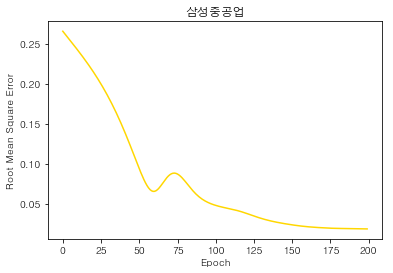

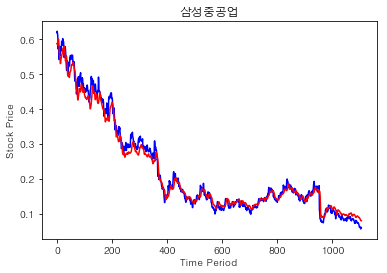

RMSE: 0.018194063
train_cnt: 199
마지막 종가(2018.07.23): 6,300
예측 종가: 7,134 (13.24%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


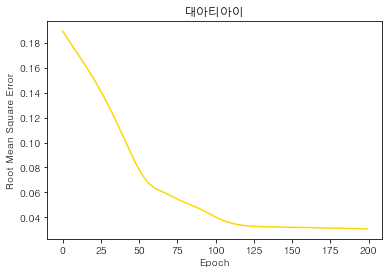

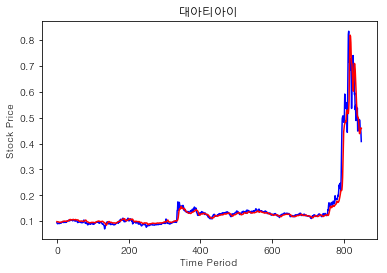

RMSE: 0.030625029
train_cnt: 199
마지막 종가(2018.07.23): 5,630
예측 종가: 6,061 (7.66%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


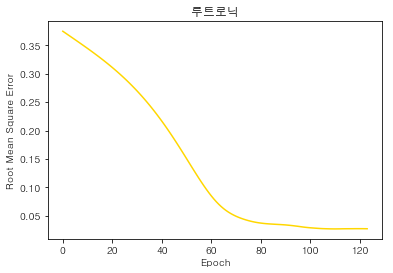

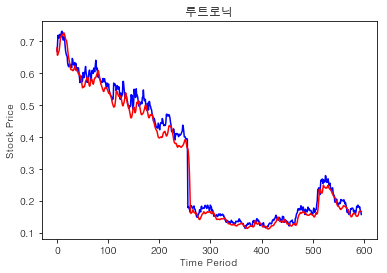

RMSE: 0.02721941
train_cnt: 110
마지막 종가(2018.07.23): 13,100
예측 종가: 13,954 (6.52%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


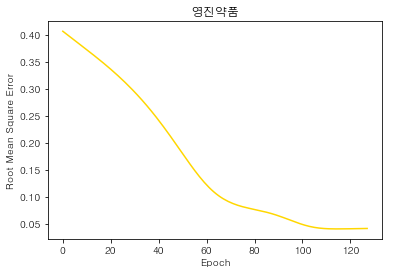

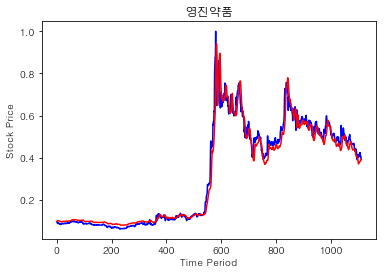

RMSE: 0.04077132
train_cnt: 114
마지막 종가(2018.07.23): 7,010
예측 종가: 7,012 (0.03%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


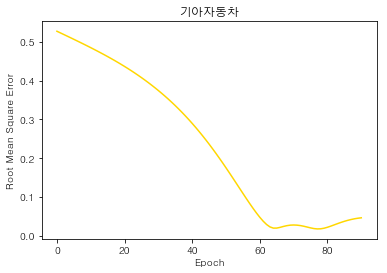

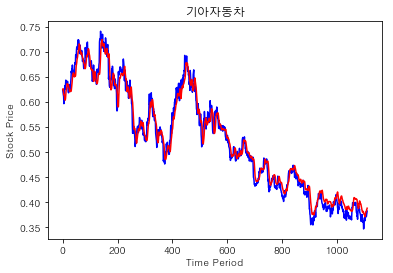

RMSE: 0.017637473
train_cnt: 77
마지막 종가(2018.07.23): 32,500
예측 종가: 32,364 (-0.42%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


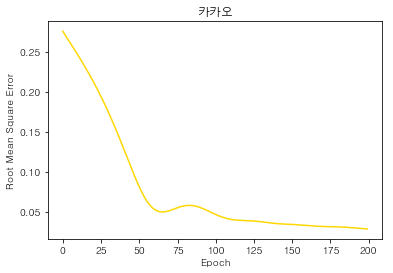

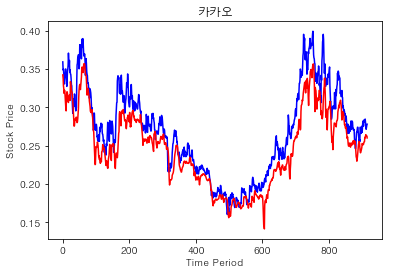

RMSE: 0.02833208
train_cnt: 199
마지막 종가(2018.07.23): 115,500
예측 종가: 113,626 (-1.62%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


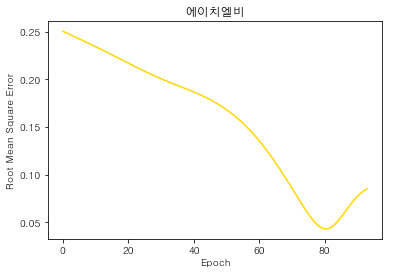

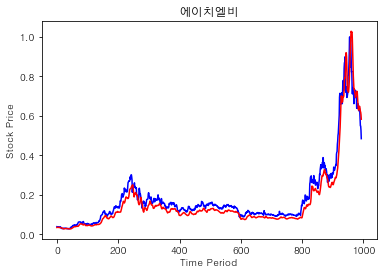

RMSE: 0.043213855
train_cnt: 80
마지막 종가(2018.07.23): 67,800
예측 종가: 78,384 (15.61%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


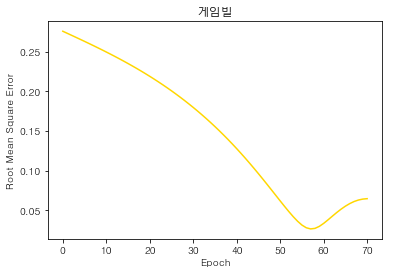

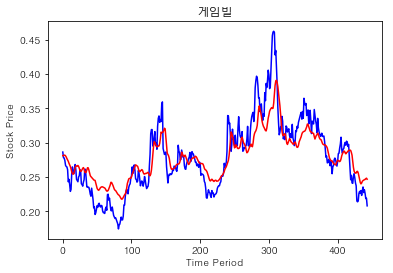

RMSE: 0.026768818
train_cnt: 57
마지막 종가(2018.07.23): 49,000
예측 종가: 57,718 (17.79%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


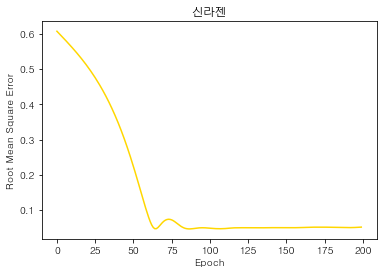

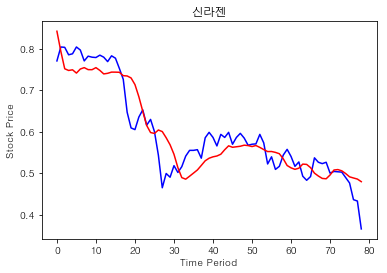

RMSE: 0.04657161
train_cnt: 87
마지막 종가(2018.07.23): 53,600
예측 종가: 65,234 (21.71%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "게임빌", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


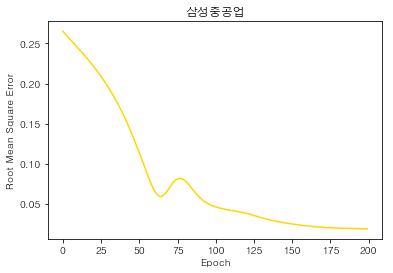

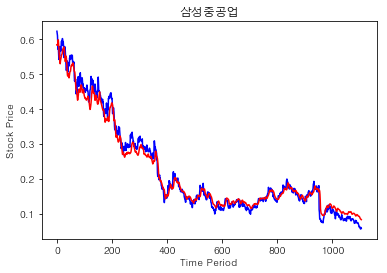

RMSE: 0.019071775
train_cnt: 199
마지막 종가(2018.07.24): 6,150
예측 종가: 7,214 (17.30%)

INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


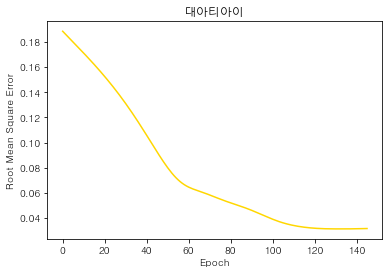

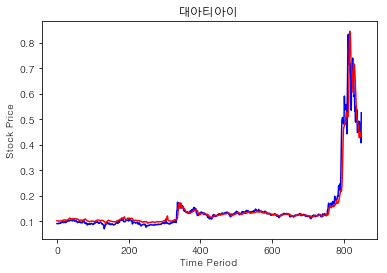

RMSE: 0.031456396
train_cnt: 132
마지막 종가(2018.07.24): 7,200
예측 종가: 5,743 (-20.23%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


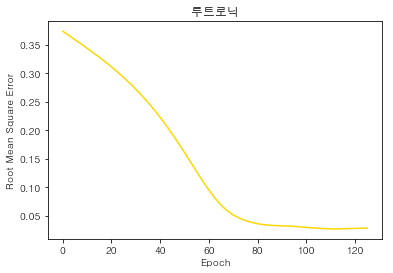

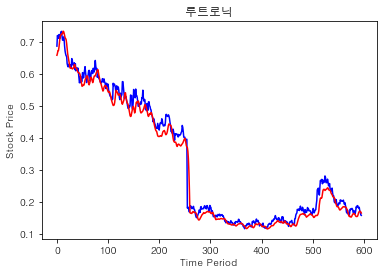

RMSE: 0.027156001
train_cnt: 112
마지막 종가(2018.07.24): 13,000
예측 종가: 13,734 (5.65%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


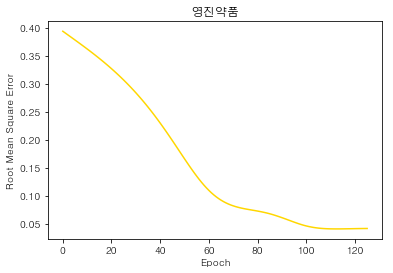

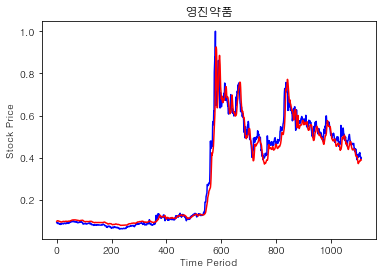

RMSE: 0.04051287
train_cnt: 112
마지막 종가(2018.07.24): 7,080
예측 종가: 6,918 (-2.28%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


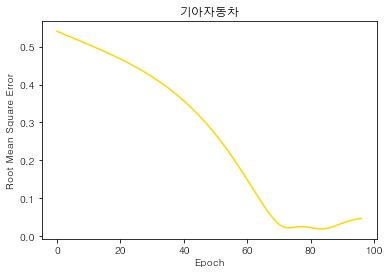

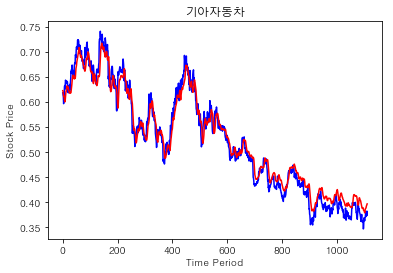

RMSE: 0.019680044
train_cnt: 83
마지막 종가(2018.07.24): 31,800
예측 종가: 32,818 (3.20%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


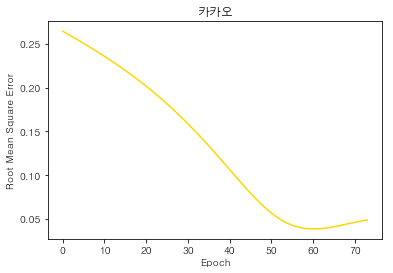

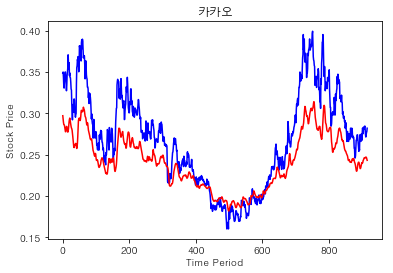

RMSE: 0.038808495
train_cnt: 60
마지막 종가(2018.07.24): 117,000
예측 종가: 112,820 (-3.57%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


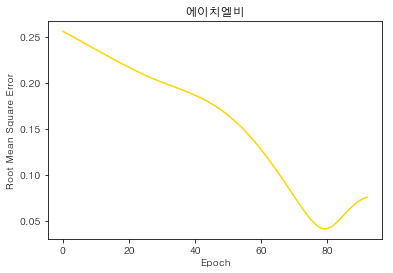

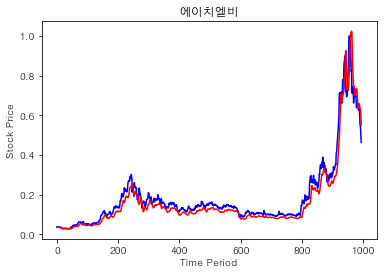

RMSE: 0.041228276
train_cnt: 79
마지막 종가(2018.07.24): 64,800
예측 종가: 74,599 (15.12%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


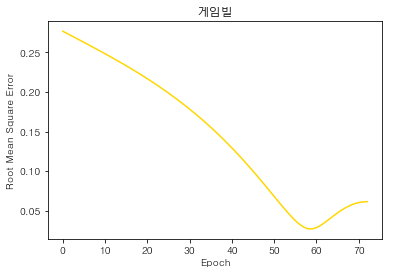

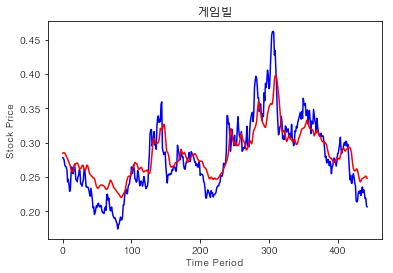

RMSE: 0.02678545
train_cnt: 59
마지막 종가(2018.07.24): 48,750
예측 종가: 56,975 (16.87%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


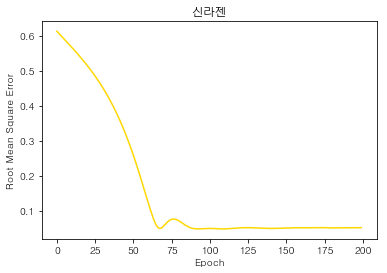

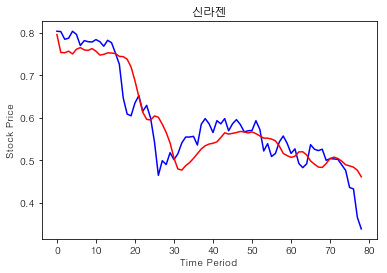

RMSE: 0.0483294
train_cnt: 109
마지막 종가(2018.07.24): 50,300
예측 종가: 61,881 (23.02%)



In [5]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "게임빌", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


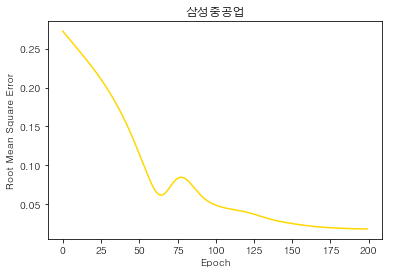

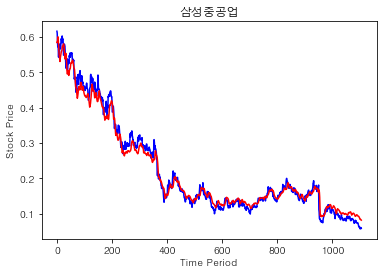

RMSE: 0.018374586
train_cnt: 199
마지막 종가(2018.07.25): 6,160
예측 종가: 7,113 (15.48%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


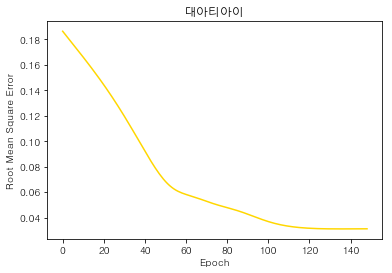

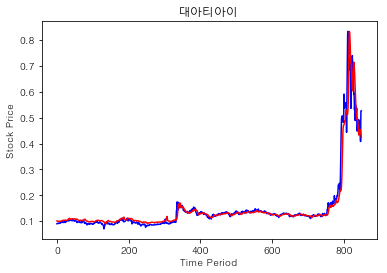

RMSE: 0.031039251
train_cnt: 135
마지막 종가(2018.07.25): 7,210
예측 종가: 5,817 (-19.33%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


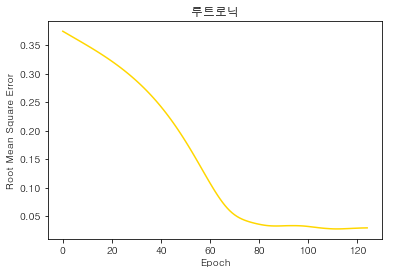

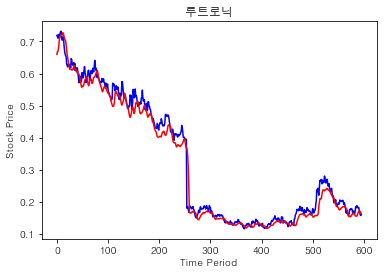

RMSE: 0.027604189
train_cnt: 111
마지막 종가(2018.07.25): 13,150
예측 종가: 13,500 (2.66%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


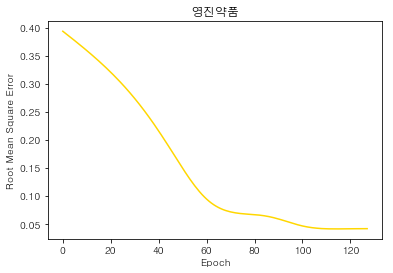

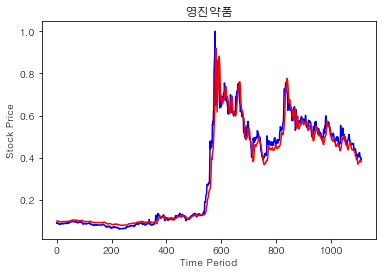

RMSE: 0.04156766
train_cnt: 114
마지막 종가(2018.07.25): 6,950
예측 종가: 6,794 (-2.25%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


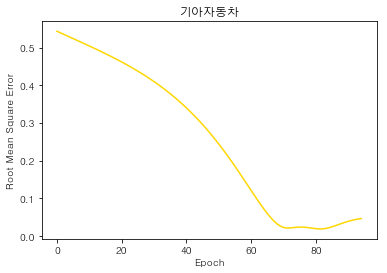

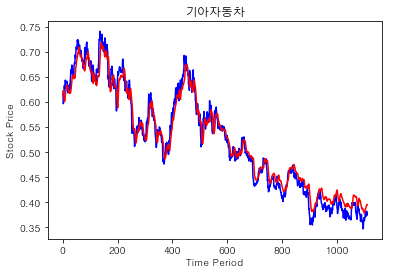

RMSE: 0.019260865
train_cnt: 81
마지막 종가(2018.07.25): 32,200
예측 종가: 32,774 (1.78%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


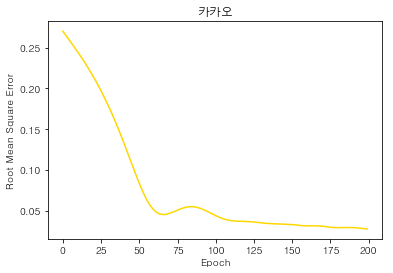

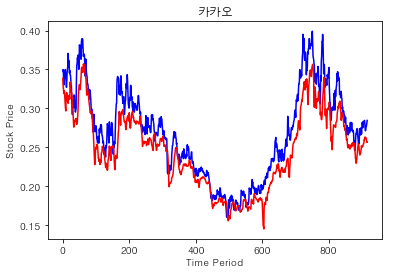

RMSE: 0.027996598
train_cnt: 199
마지막 종가(2018.07.25): 118,000
예측 종가: 114,047 (-3.35%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


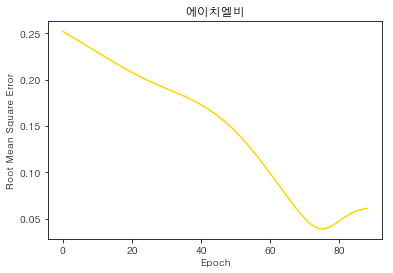

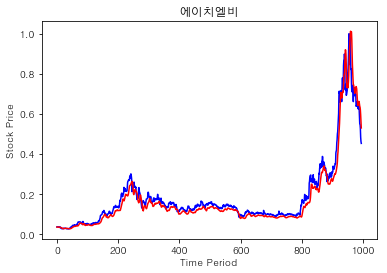

RMSE: 0.038857453
train_cnt: 75
마지막 종가(2018.07.25): 63,500
예측 종가: 72,357 (13.95%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


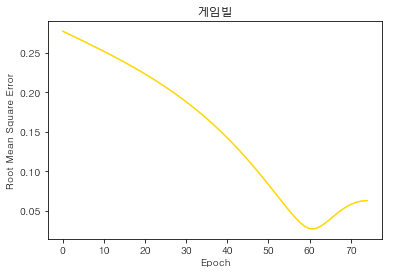

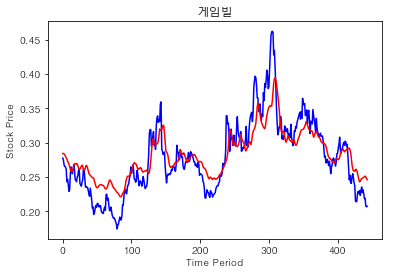

RMSE: 0.027283605
train_cnt: 61
마지막 종가(2018.07.25): 48,900
예측 종가: 56,264 (15.06%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


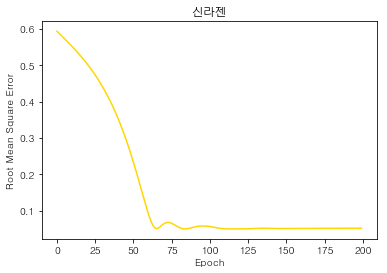

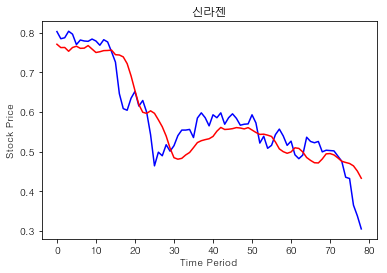

RMSE: 0.050238203
train_cnt: 114
마지막 종가(2018.07.25): 46,300
예측 종가: 58,452 (26.25%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "게임빌", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


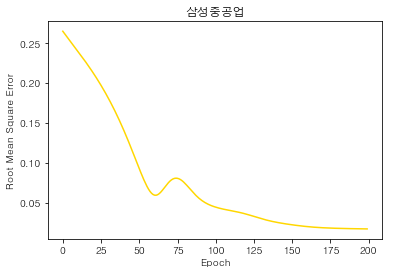

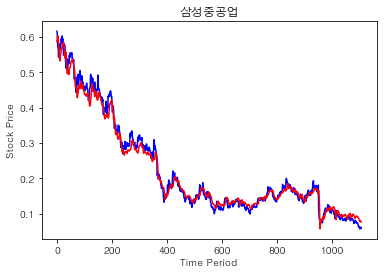

RMSE: 0.017165268
train_cnt: 199
마지막 종가(2018.07.26): 6,310
예측 종가: 6,952 (10.17%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


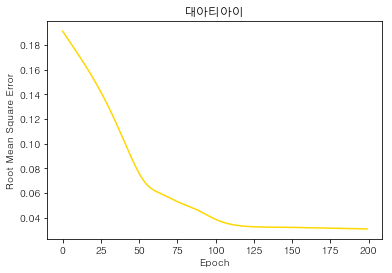

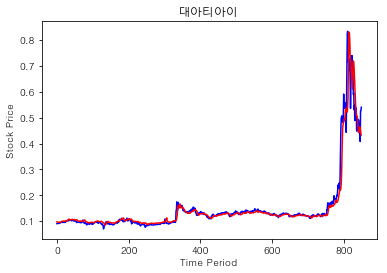

RMSE: 0.030861514
train_cnt: 199
마지막 종가(2018.07.26): 7,390
예측 종가: 6,147 (-16.82%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


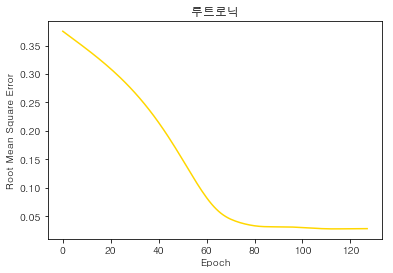

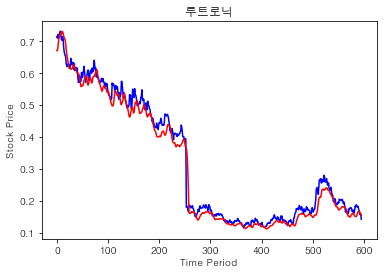

RMSE: 0.028055513
train_cnt: 114
마지막 종가(2018.07.26): 12,000
예측 종가: 13,182 (9.85%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


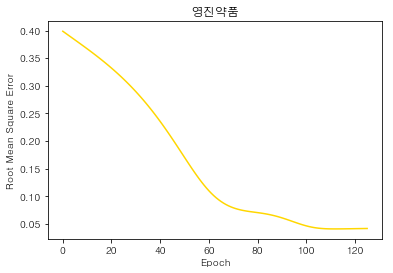

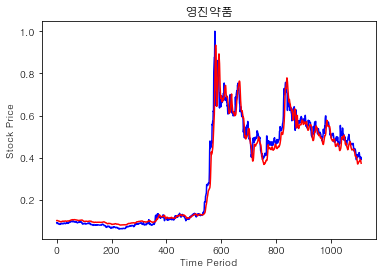

RMSE: 0.040928777
train_cnt: 112
마지막 종가(2018.07.26): 7,140
예측 종가: 6,681 (-6.43%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


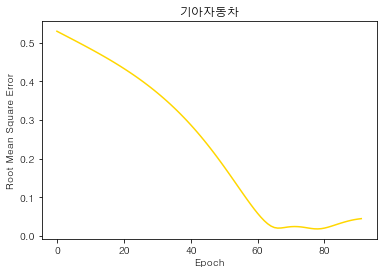

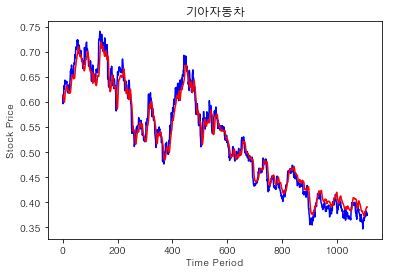

RMSE: 0.018064713
train_cnt: 78
마지막 종가(2018.07.26): 31,850
예측 종가: 32,578 (2.29%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


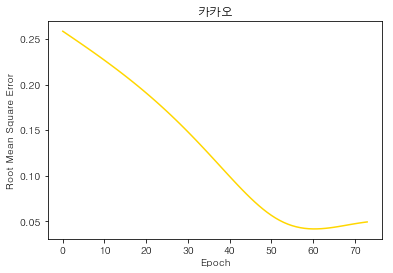

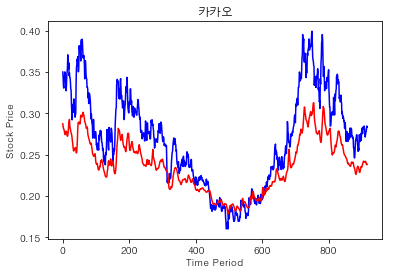

RMSE: 0.041821927
train_cnt: 60
마지막 종가(2018.07.26): 117,500
예측 종가: 113,147 (-3.70%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


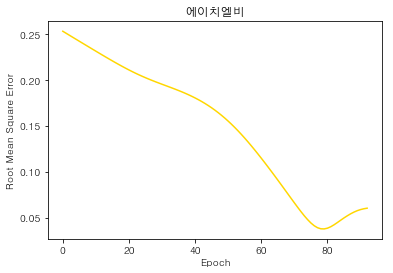

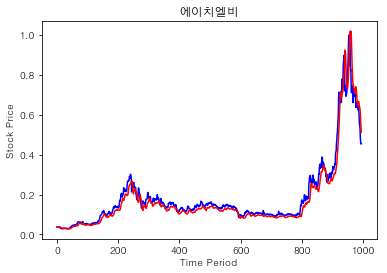

RMSE: 0.03778492
train_cnt: 79
마지막 종가(2018.07.26): 63,600
예측 종가: 69,121 (8.68%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


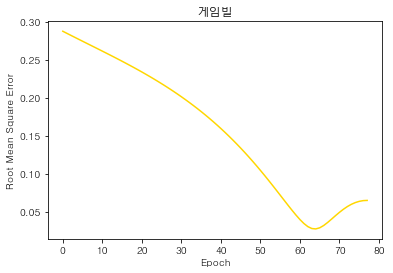

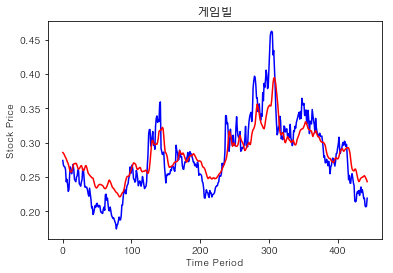

RMSE: 0.027233804
train_cnt: 64
마지막 종가(2018.07.26): 50,900
예측 종가: 55,680 (9.39%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


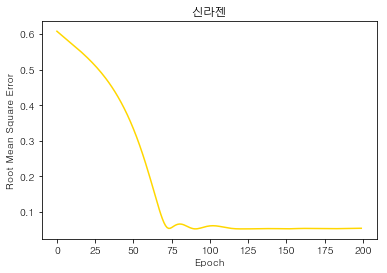

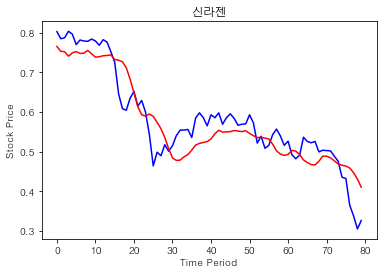

RMSE: 0.05153517
train_cnt: 122
마지막 종가(2018.07.26): 48,900
예측 종가: 55,907 (14.33%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "게임빌", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


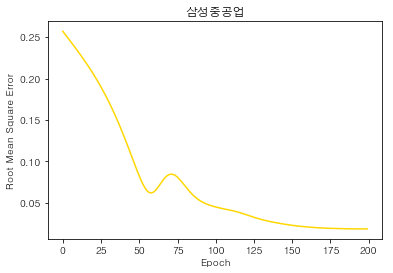

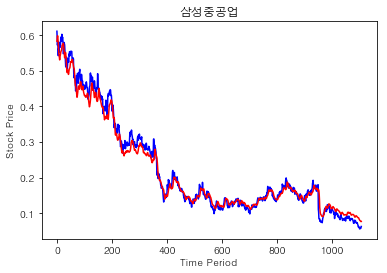

RMSE: 0.01857863
train_cnt: 199
마지막 종가(2018.07.27): 6,450
예측 종가: 7,056 (9.40%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


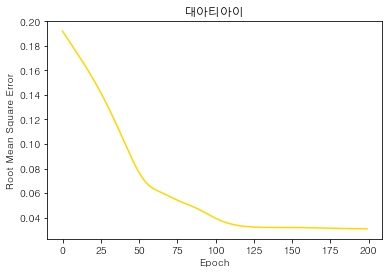

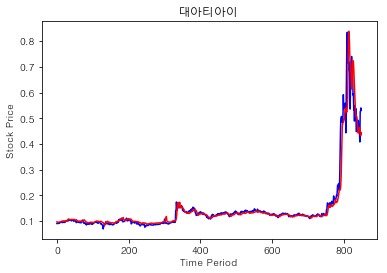

RMSE: 0.030839205
train_cnt: 199
마지막 종가(2018.07.27): 7,290
예측 종가: 6,337 (-13.07%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


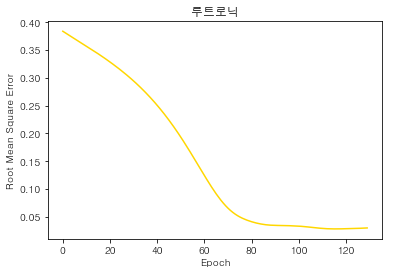

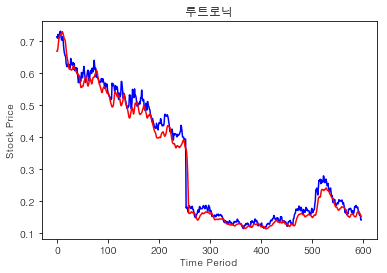

RMSE: 0.028048424
train_cnt: 116
마지막 종가(2018.07.27): 12,000
예측 종가: 12,820 (6.84%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


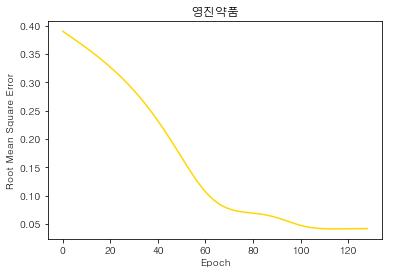

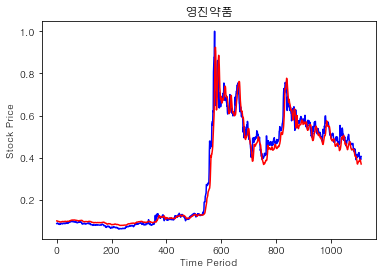

RMSE: 0.041171063
train_cnt: 115
마지막 종가(2018.07.27): 7,220
예측 종가: 6,686 (-7.39%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


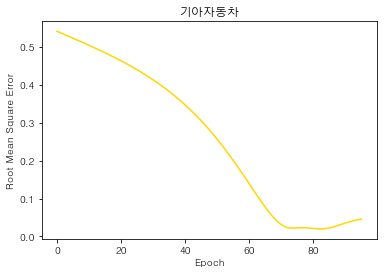

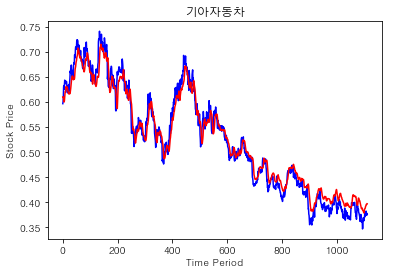

RMSE: 0.019865371
train_cnt: 82
마지막 종가(2018.07.27): 31,950
예측 종가: 32,944 (3.11%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


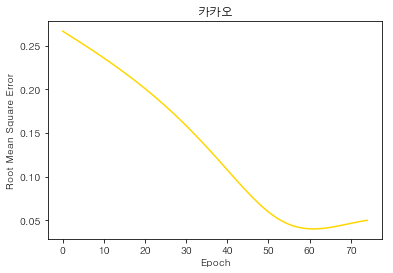

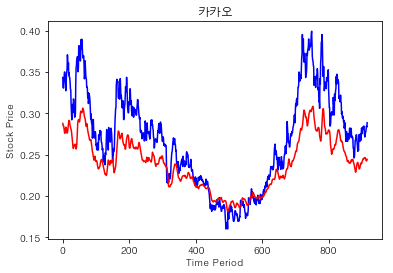

RMSE: 0.039995175
train_cnt: 61
마지막 종가(2018.07.27): 119,500
예측 종가: 114,311 (-4.34%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


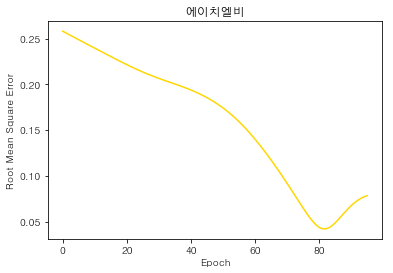

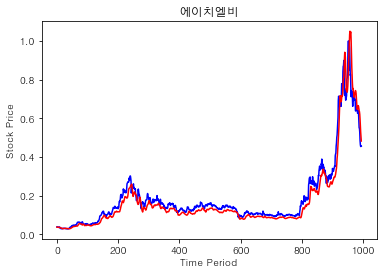

RMSE: 0.04203301
train_cnt: 82
마지막 종가(2018.07.27): 63,800
예측 종가: 65,686 (2.96%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


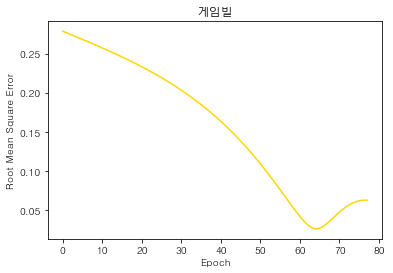

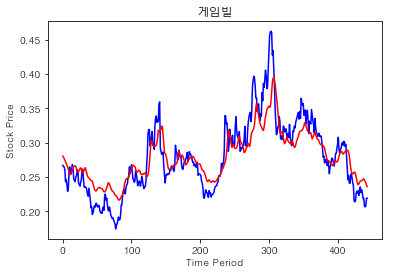

RMSE: 0.026429202
train_cnt: 64
마지막 종가(2018.07.27): 50,900
예측 종가: 54,752 (7.57%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


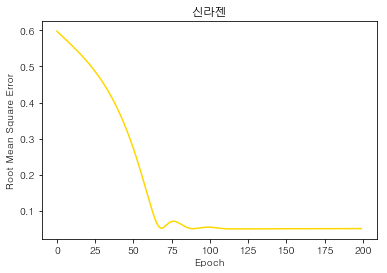

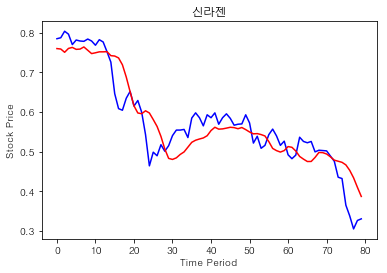

RMSE: 0.05084129
train_cnt: 116
마지막 종가(2018.07.27): 49,400
예측 종가: 52,164 (5.59%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "게임빌", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


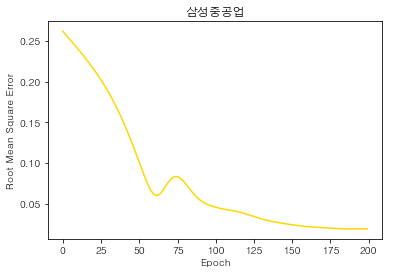

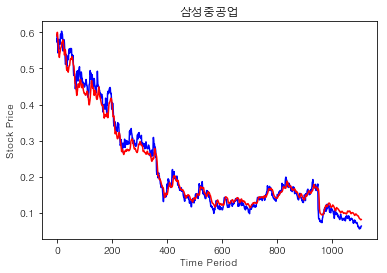

RMSE: 0.019105872
train_cnt: 191
마지막 종가(2018.07.30): 6,500
예측 종가: 7,178 (10.44%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


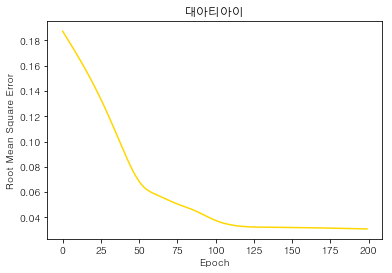

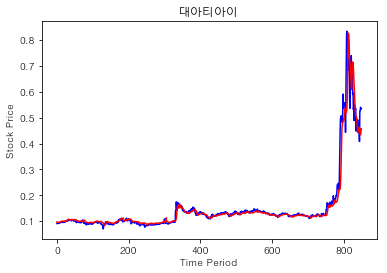

RMSE: 0.030911535
train_cnt: 199
마지막 종가(2018.07.30): 7,320
예측 종가: 6,973 (-4.74%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


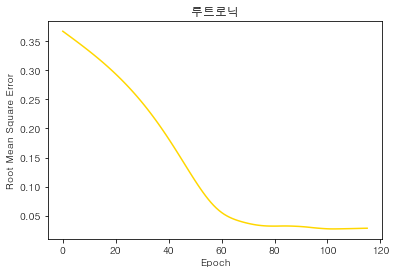

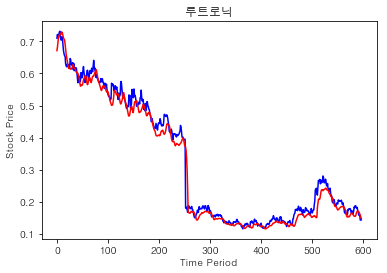

RMSE: 0.027075343
train_cnt: 102
마지막 종가(2018.07.30): 12,050
예측 종가: 12,440 (3.24%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


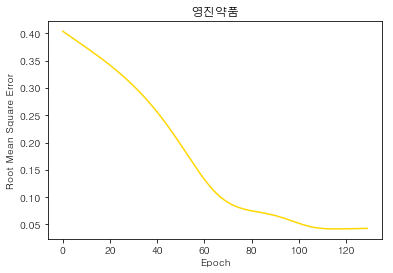

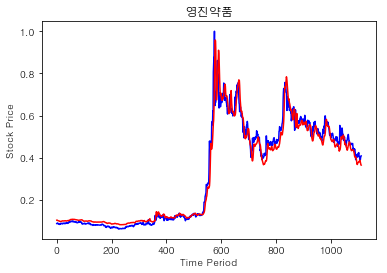

RMSE: 0.04180594
train_cnt: 116
마지막 종가(2018.07.30): 7,270
예측 종가: 6,613 (-9.04%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


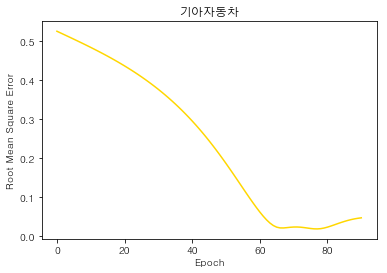

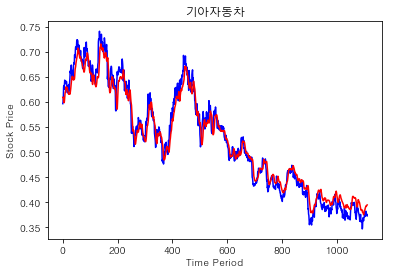

RMSE: 0.019161684
train_cnt: 77
마지막 종가(2018.07.30): 31,700
예측 종가: 32,702 (3.16%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


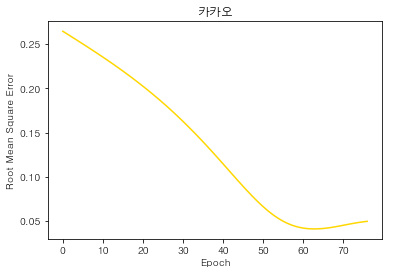

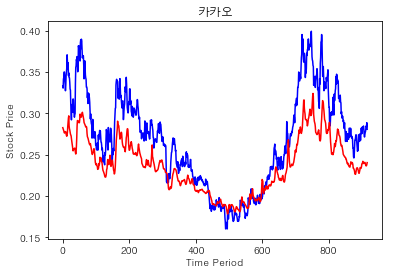

RMSE: 0.0412043
train_cnt: 63
마지막 종가(2018.07.30): 116,500
예측 종가: 113,606 (-2.48%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


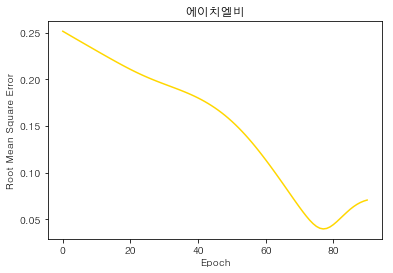

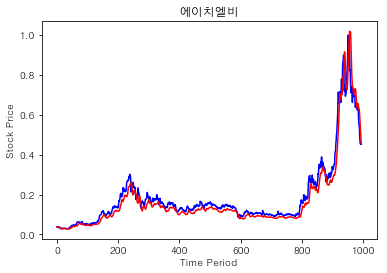

RMSE: 0.03959795
train_cnt: 77
마지막 종가(2018.07.30): 63,400
예측 종가: 64,046 (1.02%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


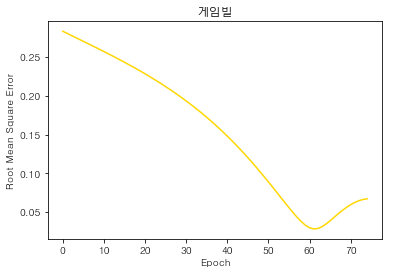

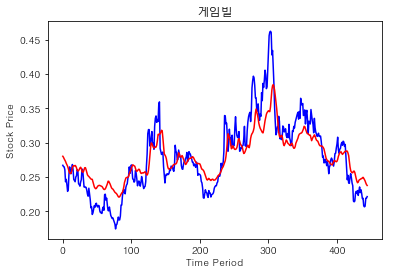

RMSE: 0.028082777
train_cnt: 61
마지막 종가(2018.07.30): 51,300
예측 종가: 55,976 (9.12%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


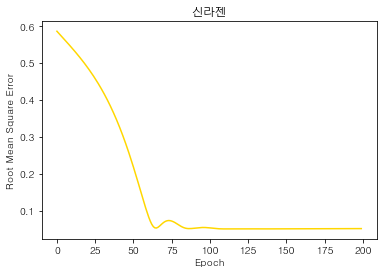

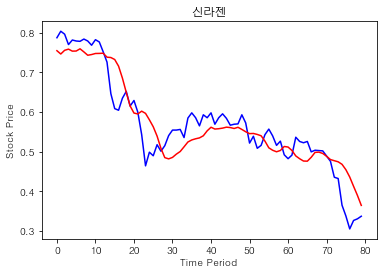

RMSE: 0.05086401
train_cnt: 109
마지막 종가(2018.07.30): 50,200
예측 종가: 50,717 (1.03%)



In [5]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "게임빌", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


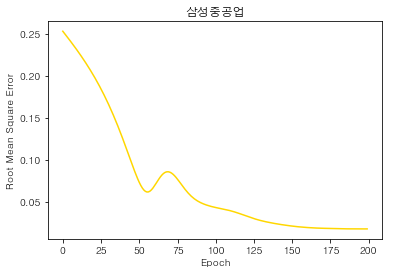

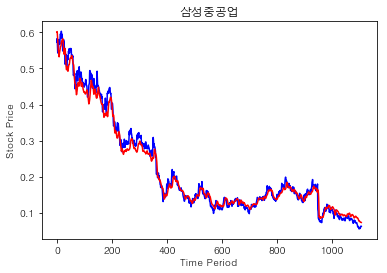

RMSE: 0.017603358
train_cnt: 198
마지막 종가(2018.07.31): 6,470
예측 종가: 7,071 (9.28%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


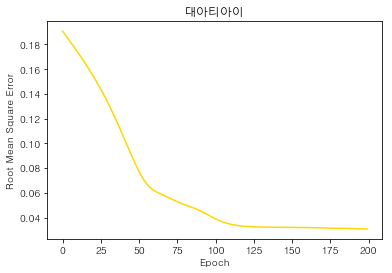

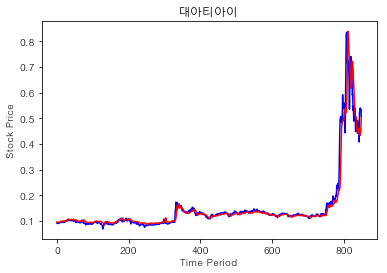

RMSE: 0.030795049
train_cnt: 199
마지막 종가(2018.07.31): 6,960
예측 종가: 7,140 (2.58%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


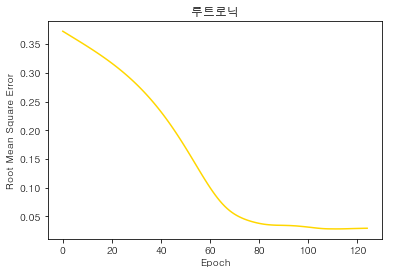

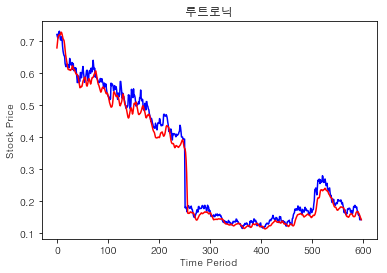

RMSE: 0.028146103
train_cnt: 111
마지막 종가(2018.07.31): 12,050
예측 종가: 12,344 (2.44%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


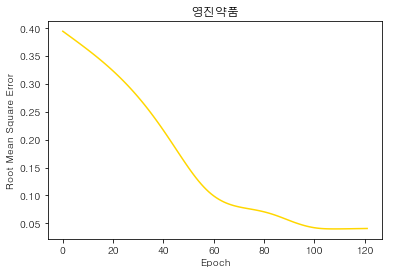

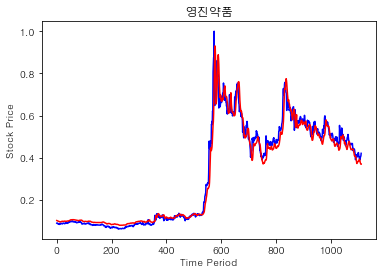

RMSE: 0.039929207
train_cnt: 108
마지막 종가(2018.07.31): 7,480
예측 종가: 6,764 (-9.58%)

INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


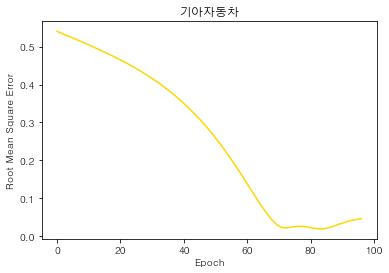

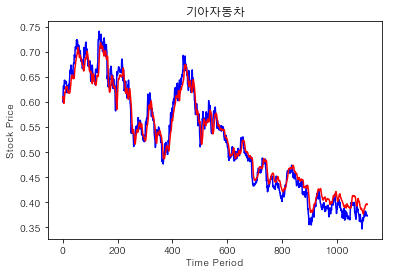

RMSE: 0.01930795
train_cnt: 83
마지막 종가(2018.07.31): 31,700
예측 종가: 32,817 (3.52%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


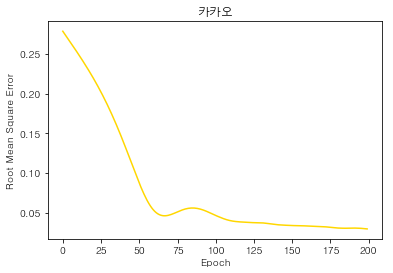

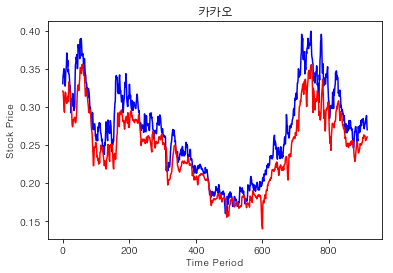

RMSE: 0.02954929
train_cnt: 199
마지막 종가(2018.07.31): 112,500
예측 종가: 116,970 (3.97%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


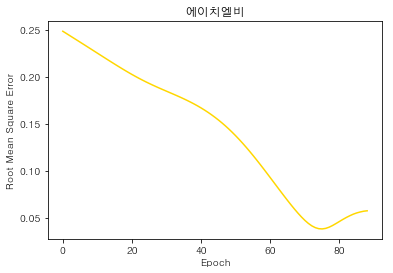

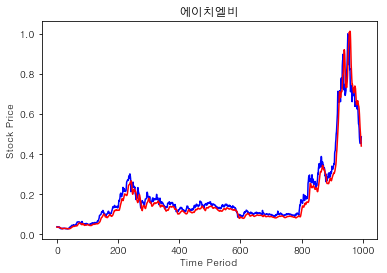

RMSE: 0.038094062
train_cnt: 75
마지막 종가(2018.07.31): 68,100
예측 종가: 61,719 (-9.37%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


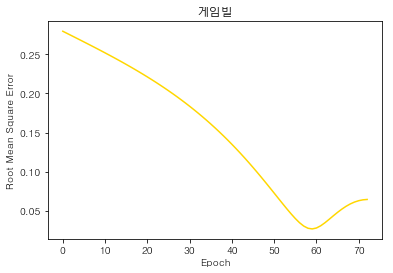

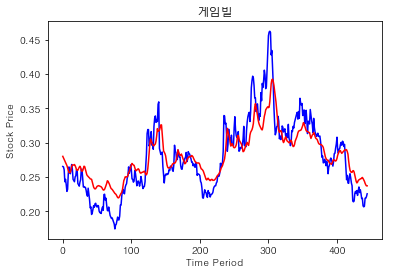

RMSE: 0.027025275
train_cnt: 59
마지막 종가(2018.07.31): 52,000
예측 종가: 55,928 (7.55%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


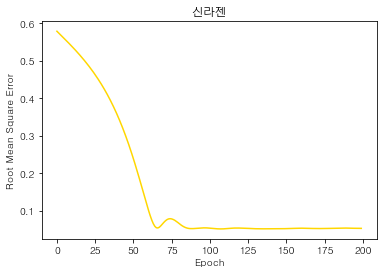

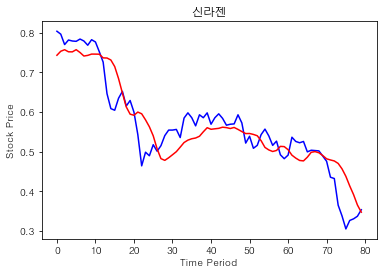

RMSE: 0.0511662
train_cnt: 107
마지막 종가(2018.07.31): 52,200
예측 종가: 49,431 (-5.31%)



In [4]:
comp_names = ["삼성중공업", "대아티아이","루트로닉", "영진약품","기아자동차", "카카오", "에이치엘비", "게임빌", "신라젠"]
for comp_name in comp_names :
    predict_next_close(comp_name)